In [1]:
# Este ambiente Python 3 vem com muitas bibliotecas de análise úteis instaladas
# Ele é definido pela imagem Docker kaggle/python: https://github.com/kaggle/docker-python
# Por exemplo, aqui estão vários pacotes úteis para carregar

import numpy as np # álgebra linear
import pandas as pd # processamento de dados, E/S de arquivos CSV (por exemplo, pd.read_csv)


import numpy as np
from sklearn.cluster import KMeans

from minisom import MiniSom  

import matplotlib.pyplot as plt
%matplotlib inline

# Os arquivos de dados de entrada estão disponíveis no diretório somente leitura "../input/"
# Por exemplo, executar isso (clicando em executar ou pressionando Shift+Enter) listará todos os arquivos no diretório de entrada

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Você pode escrever até 20GB no diretório atual (/kaggle/working/) que é preservado como saída quando você cria uma versão usando "Salvar & Executar Tudo"
# Você também pode escrever arquivos temporários em /kaggle/temp/, mas eles não serão salvos fora da sessão atual

## Introdução

Neste notebook, demonstraremos como usar o minisom para fazer clustering de topologia linear

Por favor, vote positivamente neste notebook se achar útil :)

Jonathan Kristanto &copy; Maio 2021

## Importar Dados

In [2]:
DATA_DIR = './dataset/Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## Seleção de Características

Veremos quais combinações de características podem ser agrupadas

### Distribuição de Dados de Idade e Pontuação de Gastos

Resultado: Nenhum cluster aparente detectado

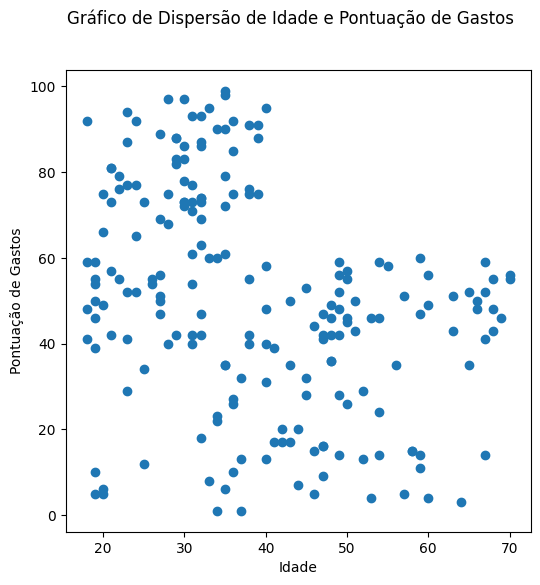

In [3]:
age = df['Age'].tolist()
spending_score = df['Spending Score (1-100)'].tolist()
annual_income = df['Annual Income (k$)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(age, spending_score)
plt.suptitle("Gráfico de Dispersão de Idade e Pontuação de Gastos")
plt.xlabel("Idade")
plt.ylabel("Pontuação de Gastos")
plt.show()

### Distribuição de Dados de Idade e Renda Anual

Resultado: Nenhum cluster aparente detectado

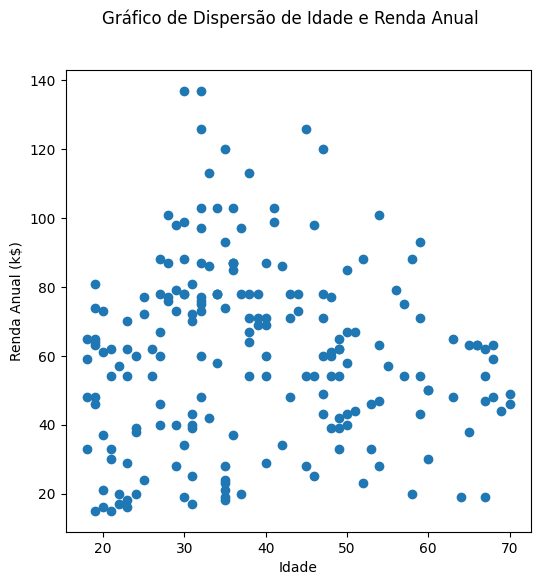

In [4]:
age = df['Age'].tolist()
annual_income = df['Annual Income (k$)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(age, annual_income)
plt.suptitle("Gráfico de Dispersão de Idade e Renda Anual")
plt.xlabel("Idade")
plt.ylabel("Renda Anual (k$)")
plt.show()

### Distribuição de Dados de Renda Anual e Pontuação de Gastos

**Resultado: Existem 5 clusters detectados**

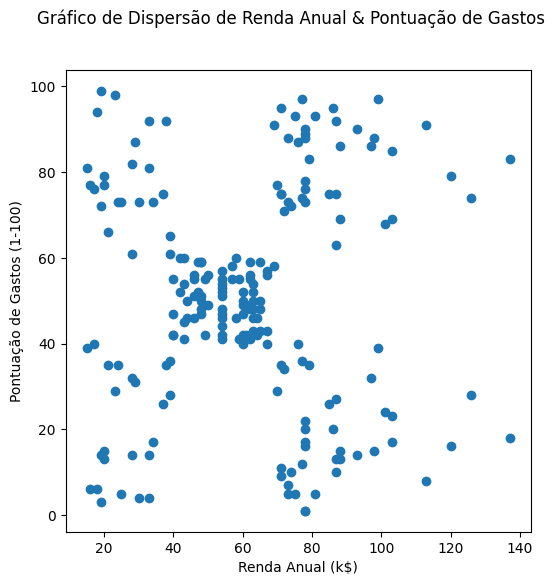

In [5]:
annual_income = df['Annual Income (k$)'].tolist()
spending_score = df['Spending Score (1-100)'].tolist()
fig = plt.figure(figsize=(6,6))
plt.scatter(annual_income, spending_score)
plt.suptitle("Gráfico de Dispersão de Renda Anual & Pontuação de Gastos")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.show()

## Limpar & Transformar Dados

In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [24]:
# Selecionar Renda Anual e Pontuação de Gastos como nossas características
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Transformar características em lista
data_all = features.values
data_all.shape

from sklearn.model_selection import train_test_split

# Divisão em treinamento e validação
data_train, data_val = train_test_split(data_all, test_size=0.5, random_state=42)

from sklearn.preprocessing import MinMaxScaler

# Criar o MinMaxScaler
scaler = MinMaxScaler()

# Ajustar e transformar os dados
data_train_normalized = scaler.fit_transform(data_train)
data_all_normalized = scaler.transform(data_all)
data_val_normalized = scaler.transform(data_val)

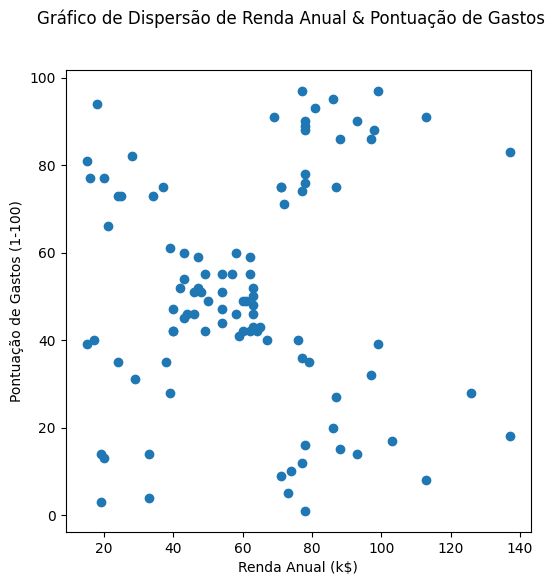

In [25]:
annual_income = data_train[:,0]
spending_score = data_train[:,1]
fig = plt.figure(figsize=(6,6))
plt.scatter(annual_income, spending_score)
plt.suptitle("Gráfico de Dispersão de Renda Anual & Pontuação de Gastos")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.show()

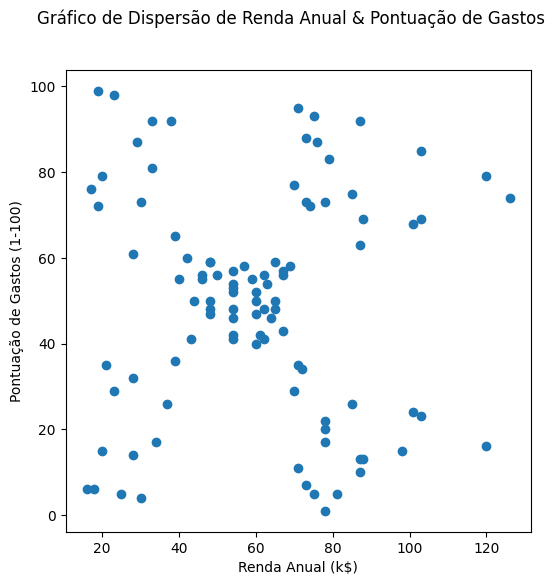

In [26]:
annual_income = data_val[:,0]
spending_score = data_val[:,1]
fig = plt.figure(figsize=(6,6))
plt.scatter(annual_income, spending_score)
plt.suptitle("Gráfico de Dispersão de Renda Anual & Pontuação de Gastos")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.show()

# Parâmetros gerais do dataset

In [11]:
global_centroid_all = np.mean(data_all_normalized, axis=0) # Calcular o centróide global
F_0_all = np.sum(np.linalg.norm(data_all_normalized - global_centroid_all, axis=1)**2) # Calcular F_0 (dispersão total)
n_0_all = data_all_normalized.shape[0] # Número total de pontos
sigma_0_all = np.sqrt(F_0_all / n_0_all) # Calcular o desvio padrão total

print(f"Número total de elementos (n_0): {n_0_all}")
print(f"Baricentro Global (m_0): ", global_centroid_all)
print(f"Dispersão total (F_0): {F_0_all:.2f}")
print(f"Desvio padrão total (\\sigma_0): {sigma_0_all:.2f}")

print('Treinamento')
global_centroid_train = np.mean(data_train_normalized, axis=0) # Calcular o centróide global
F_0_train = np.sum(np.linalg.norm(data_train_normalized - global_centroid_train, axis=1)**2) # Calcular F_0 (dispersão total)
n_0_train = data_train_normalized.shape[0] # Número total de pontos
sigma_0_train = np.sqrt(F_0_train / n_0_train) # Calcular o desvio padrão total

print(f"Número total de elementos (n_0): {n_0_train}")
print(f"Baricentro Global (m_0): ", global_centroid_train)
print(f"Dispersão total (F_0): {F_0_train:.2f}")
print(f"Desvio padrão total (\\sigma_0): {sigma_0_train:.2f}")

print('Validação')
global_centroid_val = np.mean(data_val_normalized, axis=0) # Calcular o centróide global
F_0_val = np.sum(np.linalg.norm(data_val_normalized - global_centroid_val, axis=1)**2) # Calcular F_0 (dispersão total)
n_0_val = data_val_normalized.shape[0] # Número total de pontos
sigma_0_val = np.sqrt(F_0_val / n_0_val) # Calcular o desvio padrão total

print(f"Número total de elementos (n_0): {n_0_val}")
print(f"Baricentro Global (m_0): ", global_centroid_val)
print(f"Dispersão total (F_0): {F_0_val:.2f}")
print(f"Desvio padrão total (\\sigma_0): {sigma_0_val:.2f}")

Número total de elementos (n_0): 200
Baricentro Global (m_0):  [0.37344262 0.50204082]
Dispersão total (F_0): 23.04
Desvio padrão total (\sigma_0): 0.34
Treinamento
Número total de elementos (n_0): 100
Baricentro Global (m_0):  [0.37901639 0.521875  ]
Dispersão total (F_0): 12.14
Desvio padrão total (\sigma_0): 0.35
Validação
Número total de elementos (n_0): 100
Baricentro Global (m_0):  [0.39890909 0.49285714]
Dispersão total (F_0): 12.13
Desvio padrão total (\sigma_0): 0.35


# Treinamento dos Modelos

## K-means

In [12]:
import numpy as np
from sklearn.cluster import KMeans

# Função para calcular a dispersão intra-cluster F_j
def calcular_dispersaointra(cluster_points, centroid):
    return np.sum(np.linalg.norm(cluster_points - centroid, axis=1)**2)

# Função para calcular o diâmetro máximo do cluster
def calcular_diametro(cluster_points):
    max_distance = 0
    for i in range(len(cluster_points)):
        for k in range(i + 1, len(cluster_points)):
            dist = np.linalg.norm(cluster_points[i] - cluster_points[k])
            max_distance = max(max_distance, dist)
    return max_distance

# Função para calcular a variância intra-cluster
def calcular_variancia_intra(cluster_points, centroid):
    return np.mean(np.linalg.norm(cluster_points - centroid, axis=1)**2)

# Função para calcular o desvio padrão intra-cluster
def calcular_desvio_padrao_intra(variancia_intra):
    return np.sqrt(variancia_intra)

# Função para calcular a dispersão inter-cluster F_out
def calcular_dispersaointer(centroids, data, labels, n_clusters):
    F_out = 0
    global_centroid = np.mean(centroids, axis=0)  # Centróide global (média dos centróides dos clusters)
    for j in range(n_clusters):
        cluster_points = data[labels == j]  # Dados no cluster j
        n_j = len(cluster_points)           # Número de pontos no cluster j
        centroid_j = centroids[j]           # Centróide do cluster j
        F_out += n_j * np.linalg.norm(centroid_j - global_centroid)**2
    return F_out

# Função principal para calcular as métricas do KMeans
def calcular_metricas_cluster_kmeans(data, max_clusters=10):
    # Inicialização das listas para armazenar os resultados
    F_out_values = []
    F_in_values = []
    n_cluster_points_values = []
    centroid_values = []
    max_distance_values = []
    variancia_intra_values = []
    desvio_padrao_intra_values = []

    # Loop para diferentes números de clusters
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(data)
        
        # Obter os rótulos e centróides
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        # Calcular F_j para cada cluster
        F_j_values = []
        n_cluster_points_l_values = []
        max_distance_l_values = []
        variancia_intra_l_values = []
        desvio_padrao_intra_l_values = []
        
        # Loop sobre cada cluster
        for j in range(n_clusters):
            cluster_points = data[labels == j]  # Dados no cluster j
            centroid = centroids[j]             # Centróide do cluster j

            n_cluster_points_l_values.append(len(cluster_points))
            centroid_values.append(centroid)
            
            # Calcular dispersão intra-cluster F_j
            F_j = calcular_dispersaointra(cluster_points, centroid)
            F_j_values.append(float(F_j))
            
            # Calcular o diâmetro do cluster (maior distância entre os pontos dentro do cluster)
            max_distance = calcular_diametro(cluster_points)
            max_distance_l_values.append(float(max_distance))
            
            # Calcular a variância intra-classe
            variancia_intra = calcular_variancia_intra(cluster_points, centroid)
            variancia_intra_l_values.append(float(variancia_intra))
            
            # Calcular o desvio padrão intra-classe
            desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
            desvio_padrao_intra_l_values.append(float(desvio_padrao_intra))
        
        F_in_values.append(F_j_values.copy())
        
        # Calcular F_out (dispersão inter-cluster)
        F_out = calcular_dispersaointer(centroids, data, labels, n_clusters)
        
        F_out_values.append(F_out)
        n_cluster_points_values.append(n_cluster_points_l_values)
        max_distance_values.append(max_distance_l_values.copy())
        variancia_intra_values.append(variancia_intra_l_values.copy())
        desvio_padrao_intra_values.append(desvio_padrao_intra_l_values.copy())

    return F_out_values, F_in_values, n_cluster_points_values, centroid_values, max_distance_values, variancia_intra_values, desvio_padrao_intra_values


def plot_metricas_clusters(F_out_values, F_in_values, max_clusters=10):
    # Número de clusters de 1 a max_clusters
    clusters_range = range(1, max_clusters + 1)

    # Calcular a dispersão total intra-cluster (F_in) para cada número de clusters
    total_F_in_values = [sum(F_in) for F_in in F_in_values]

    # Plotar as métricas
    plt.figure(figsize=(10, 6))

    # Gráfico da dispersão intra-cluster (F_in)
    plt.plot(clusters_range, total_F_in_values, label="Dispersão Intra-cluster (F_in)", marker='o', color='blue')

    # Gráfico da dissimilaridade inter-cluster (F_out)
    plt.plot(clusters_range, F_out_values, label="Dissimilaridade Inter-cluster (F_out)", marker='x', color='red')

    # Adicionando rótulos e título
    plt.xlabel("Número de clusters")
    plt.ylabel("Valor das métricas")
    plt.title("Dispersão intra-cluster (F_in) e Dissimilaridade inter-cluster (F_out) por número de clusters")
    plt.legend()
    plt.grid(True)

    # Exibir o gráfico
    plt.show()



Total


Clusters: 1
   Número de elementos (n_j):  [200]
   Baricentro (m_j):  [0.37344262 0.50204082]
   Diâmetro do cluster:  [1.272263362016784]
   Variância intra-cluster:  [0.11520360163019953]
   Desvio padrão intra-cluster:  [0.3394165606304435]
   Dispersão intra-cluster (F_ji):  [23.040720326039906]
   Dispersão total intra-cluster (F_in): 23.040720326039906
   Dissimilaridade inter-cluster (F_out): 0.0
Clusters: 2
   Número de elementos (n_j):  [121, 79]
   Baricentro (m_j):  [0.36322991 0.67271041]
   Diâmetro do cluster:  [1.0002082248851303, 1.0227015045197394]
   Variância intra-cluster:  [0.06672669989565204, 0.07610192242616085]
   Desvio padrão intra-cluster:  [0.2583151174353759, 0.2758657688553635]
   Dispersão intra-cluster (F_ji):  [8.073930687373897, 6.012051871666707]
   Dispersão total intra-cluster (F_in): 14.085982559040605
   Dissimilaridade inter-cluster (F_out): 9.367860411130142
Clusters: 3
   Número de elementos (n_j):  [111, 50, 39]
   Baricentro (m_j)

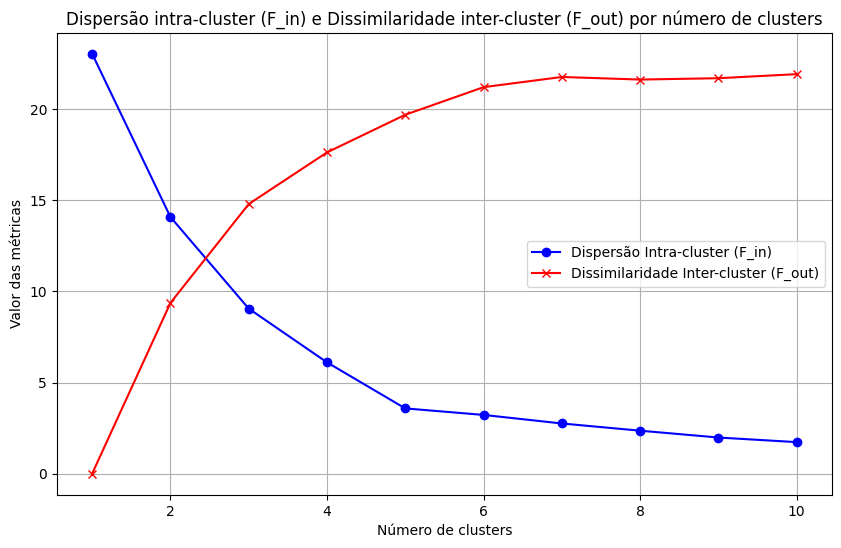



Treino


Clusters: 1
   Número de elementos (n_j):  [100]
   Baricentro (m_j):  [0.37901639 0.521875  ]
   Diâmetro do cluster:  [1.276693249687163]
   Variância intra-cluster:  [0.12144108302119726]
   Desvio padrão intra-cluster:  [0.3484839781413161]
   Dispersão intra-cluster (F_ji):  [12.144108302119726]
   Dispersão total intra-cluster (F_in): 12.144108302119726
   Dissimilaridade inter-cluster (F_out): 0.0
Clusters: 2
   Número de elementos (n_j):  [36, 64]
   Baricentro (m_j):  [0.39913479 0.81655093]
   Diâmetro do cluster:  [1.0002169903464837, 1.02364620963495]
   Variância intra-cluster:  [0.07612162725318711, 0.07025868109047205]
   Desvio padrão intra-cluster:  [0.27590148106377954, 0.2650635416093131]
   Dispersão intra-cluster (F_ji):  [2.7403785811147356, 4.496555589790211]
   Dispersão total intra-cluster (F_in): 7.236934170904947
   Dissimilaridade inter-cluster (F_out): 5.324624708349369
Clusters: 3
   Número de elementos (n_j):  [59, 20, 21]
   Baricentro (m_j): 

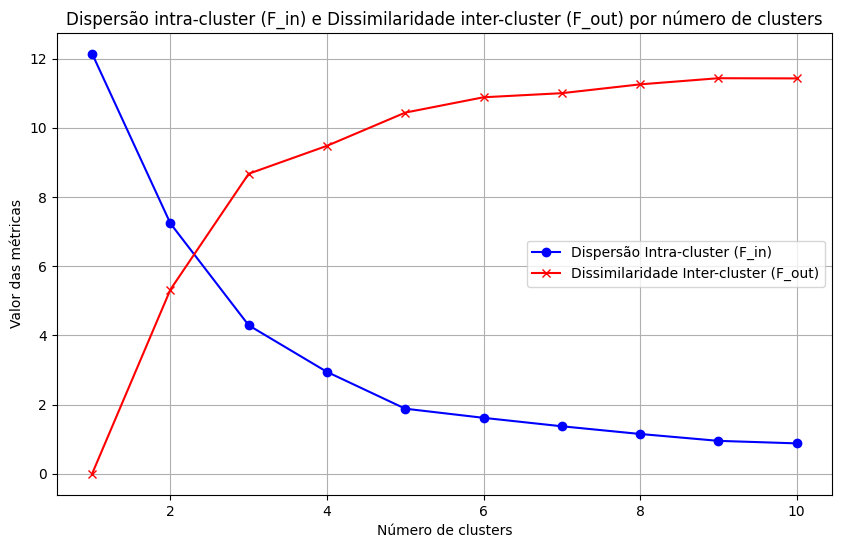



Teste


Clusters: 1
   Número de elementos (n_j):  [100]
   Baricentro (m_j):  [0.39890909 0.49285714]
   Diâmetro do cluster:  [1.2491449638462273]
   Variância intra-cluster:  [0.12132244332079262]
   Desvio padrão intra-cluster:  [0.3483137139430382]
   Dispersão intra-cluster (F_ji):  [12.132244332079262]
   Dispersão total intra-cluster (F_in): 12.132244332079262
   Dissimilaridade inter-cluster (F_out): 0.0
Clusters: 2
   Número de elementos (n_j):  [62, 38]
   Baricentro (m_j):  [0.39325513 0.66277156]
   Diâmetro do cluster:  [1.0056218963089918, 0.9509451223478912]
   Variância intra-cluster:  [0.07059773263886267, 0.07998559024454309]
   Desvio padrão intra-cluster:  [0.26570233841436675, 0.282817238237953]
   Dispersão intra-cluster (F_ji):  [4.377059423609485, 3.0394524292926373]
   Dispersão total intra-cluster (F_in): 7.416511852902122
   Dissimilaridade inter-cluster (F_out): 5.003960610332278
Clusters: 3
   Número de elementos (n_j):  [57, 31, 12]
   Baricentro (m_j):

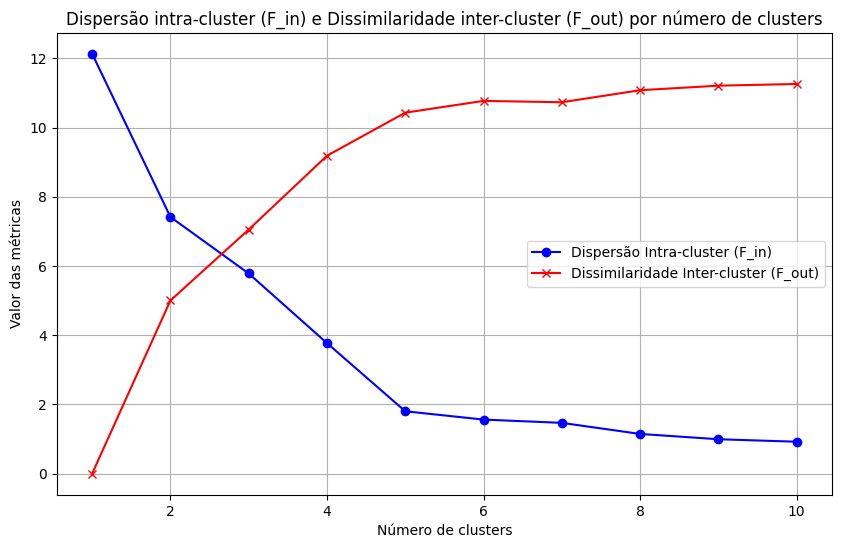

In [15]:

for i, data_normalized in enumerate([data_all_normalized, data_train_normalized, data_val_normalized]):
    print()
    print()
    if i == 0:
        print("Total")
    elif i == 1:
        print("Treino")
    elif i == 2:
        print("Teste")
    print()
    print()
    F_out_values, F_in_values, n_cluster_points_values, centroid_values, max_distance_values, variancia_intra_values, desvio_padrao_intra_values = calcular_metricas_cluster_kmeans(data_normalized, 10)
    for idx, (F_out, F_in, n_cluster_points, centroid, max_distance, variancia_intra, desvio_padrao_intra) in enumerate(zip(F_out_values, F_in_values, n_cluster_points_values, centroid_values, max_distance_values, variancia_intra_values, desvio_padrao_intra_values)):
        print(f"Clusters: {idx+1}")
        print(f"   Número de elementos (n_j): ", n_cluster_points)
        print(f"   Baricentro (m_j): ", centroid)
        print(f"   Diâmetro do cluster: ", max_distance)
        print(f"   Variância intra-cluster: ", variancia_intra)
        print(f"   Desvio padrão intra-cluster: ", desvio_padrao_intra)
        print(f"   Dispersão intra-cluster (F_ji): ", F_in)
        print(f"   Dispersão total intra-cluster (F_in): {sum(F_in)}")
        print(f"   Dissimilaridade inter-cluster (F_out): {(F_out)}")
    
    plot_metricas_clusters(F_out_values, F_in_values, max_clusters=10)



Total


Clusters: 3


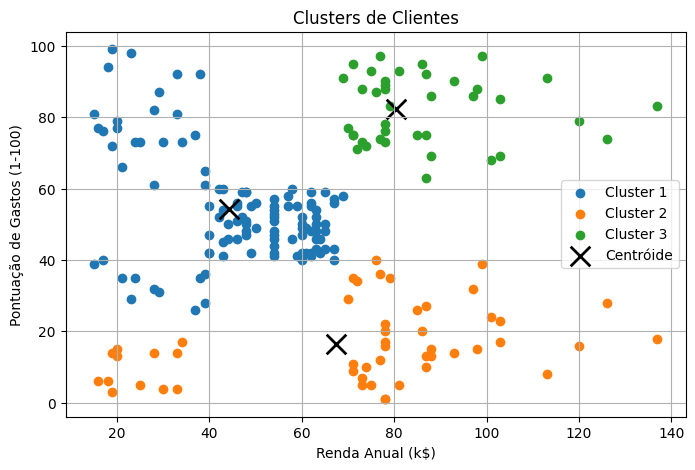

Clusters: 4


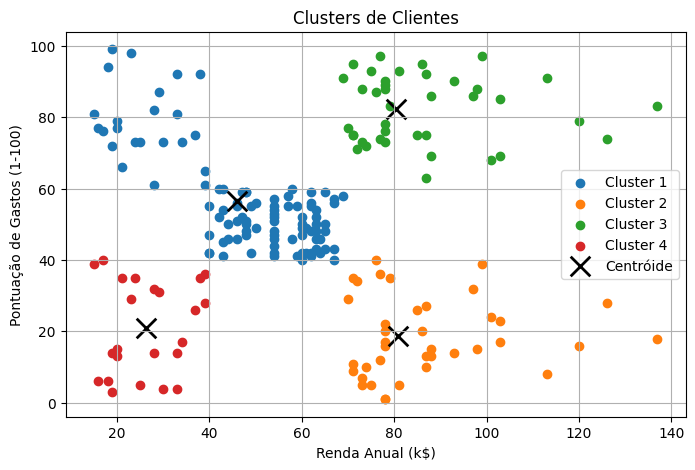

Clusters: 5


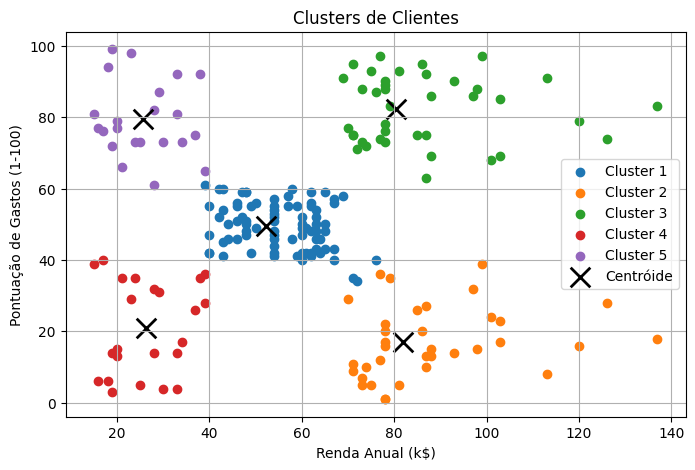



Treino


Clusters: 3


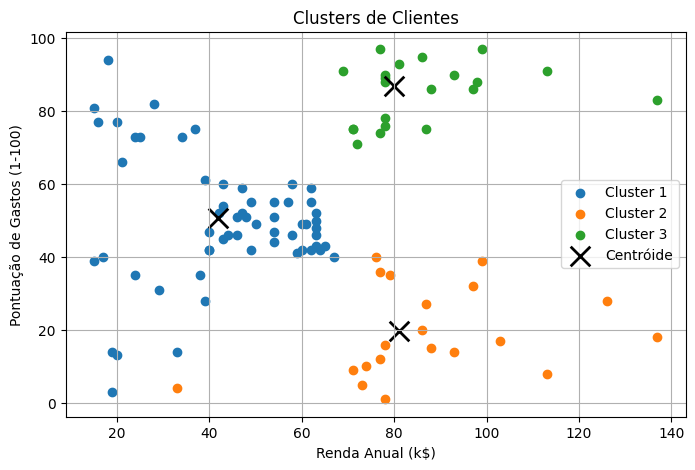

Clusters: 4


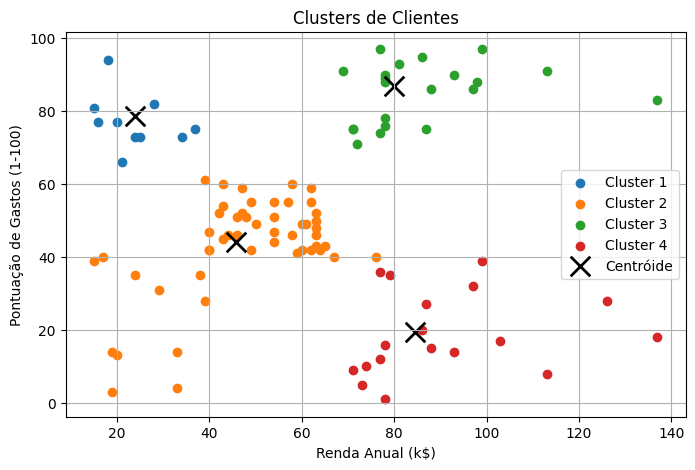

Clusters: 5


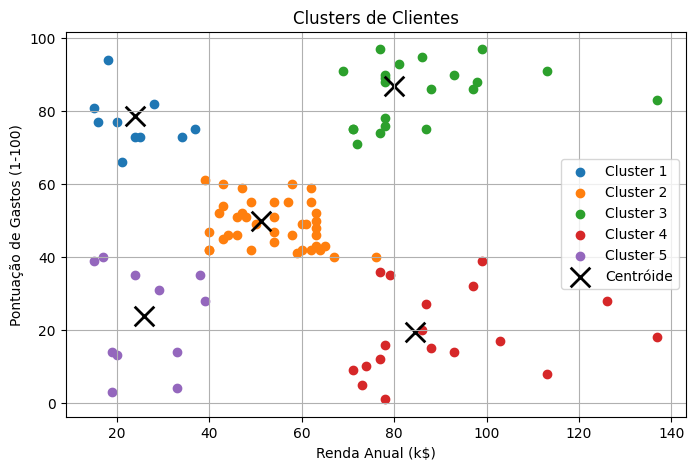



Teste


Clusters: 3


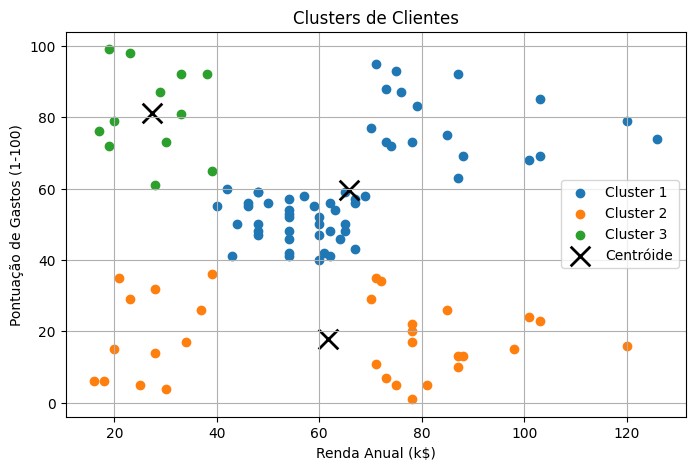

Clusters: 4


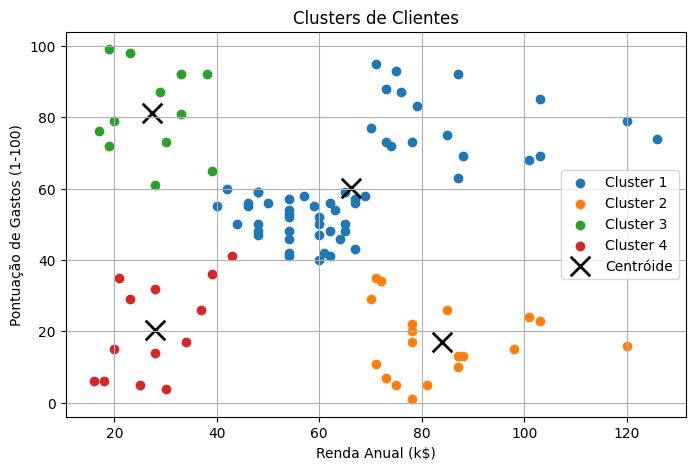

Clusters: 5


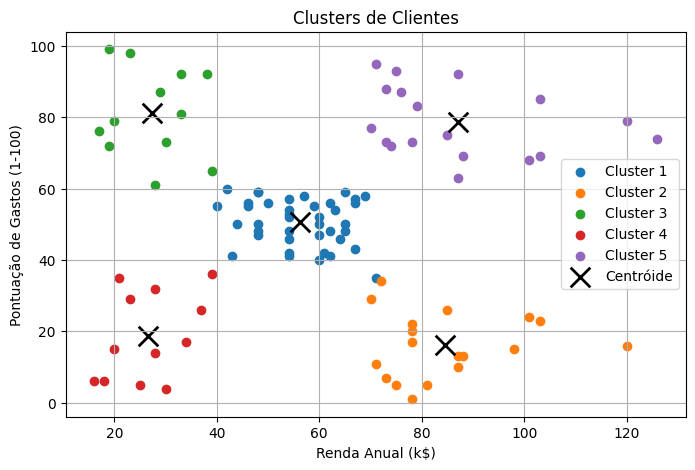

In [18]:
## Testando o valor da heurística maior queda (3) e observaçõa (5)
for i, (data, data_normalized) in enumerate([(data_all, data_all_normalized), (data_train, data_train_normalized), (data_val, data_val_normalized)]):
    print()
    print()
    if i == 0:
        print("Total")
    elif i == 1:
        print("Treino")
    elif i == 2:
        print("Teste")
    print()
    print()
    for optimal_clusters in [3, 4, 5]:
        print(f"Clusters: {optimal_clusters}")
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
        kmeans.fit(data_normalized)
        
        # Obtendo os centróides e rótulos
        m_0 = scaler.inverse_transform(kmeans.cluster_centers_)
        labels = kmeans.labels_
    
        # Plotando os clusters e seus centróides
        plt.figure(figsize=(8, 5))
        for i in range(optimal_clusters):
            cluster_points = data[labels == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}")
        
        plt.scatter(m_0[:, 0], m_0[:, 1], marker='x', s=200, linewidths=2, color='k', label='Centróide')
        plt.title("Clusters de Clientes")
        plt.xlabel("Renda Anual (k$)")
        plt.ylabel("Pontuação de Gastos (1-100)")
        plt.legend()
        plt.grid()
        plt.show()

Clusters: 3


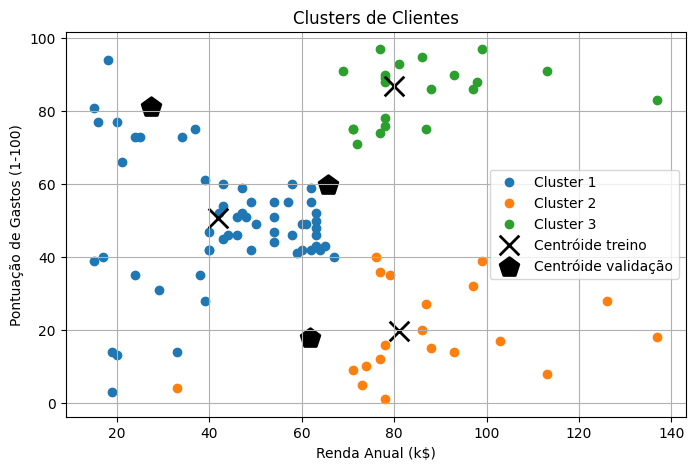

Clusters: 4


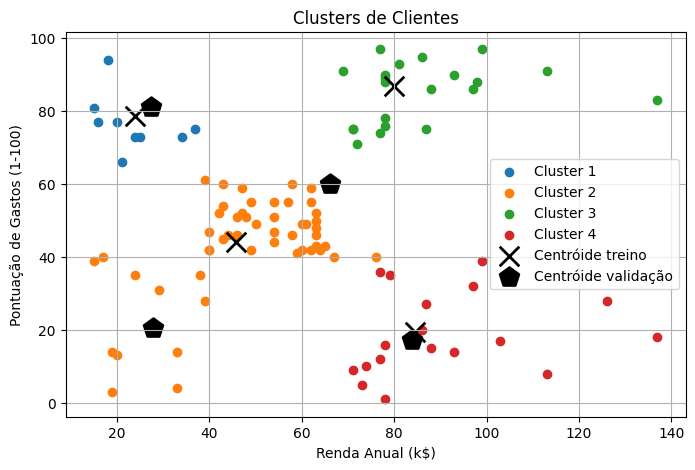

Clusters: 5


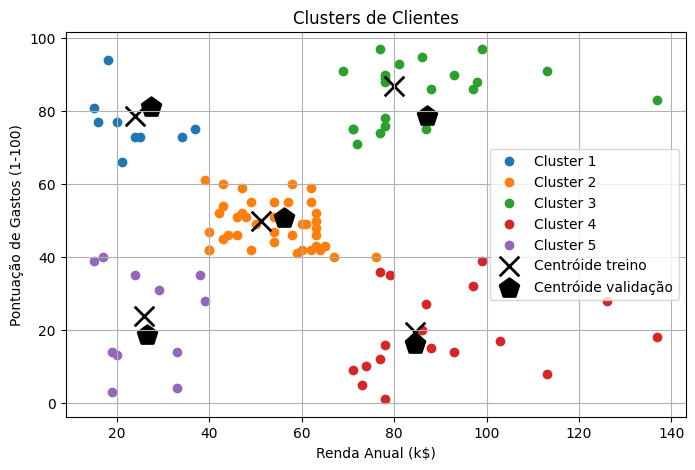

In [23]:
## Testando o valor da heurística maior queda (3) e observaçõa (5)
data, data_normalized = ((data_train, data_val), (data_train_normalized, data_val_normalized))
for optimal_clusters in [3, 4, 5]:
    print(f"Clusters: {optimal_clusters}")
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    kmeans.fit(data_normalized[0])
    
    # Obtendo os centróides e rótulos
    m_0 = scaler.inverse_transform(kmeans.cluster_centers_)
    labels = kmeans.labels_

    kmeans_val = KMeans(n_clusters=optimal_clusters, random_state=0)
    kmeans_val.fit(data_normalized[1])
    
    # Obtendo os centróides e rótulos
    m_0_val = scaler.inverse_transform(kmeans_val.cluster_centers_)
    labels_val = kmeans_val.labels_

    # Plotando os clusters e seus centróides
    plt.figure(figsize=(8, 5))
    for i in range(optimal_clusters):
        cluster_points = data[0][labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}")
    
    plt.scatter(m_0[:, 0], m_0[:, 1], marker='x', s=200, linewidths=2, color='k', label='Centróide treino')
    plt.scatter(m_0_val[:, 0], m_0_val[:, 1], marker='p', s=200, linewidths=2, color='k', label='Centróide validação')
    plt.title("Clusters de Clientes")
    plt.xlabel("Renda Anual (k$)")
    plt.ylabel("Pontuação de Gastos (1-100)")
    plt.legend()
    plt.grid()
    plt.show()

## SOM

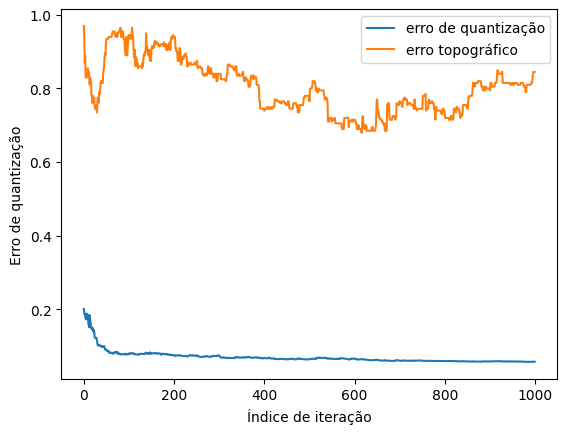

In [76]:
data_normalized, data, n_0 = data_all_normalized, data_all, n_0_all

# Eu uso topografia linear som
som_shape = (1, int(5*np.sqrt(n_0)))

som = MiniSom(som_shape[0], som_shape[1], data_normalized.shape[1], sigma=0.5, learning_rate=0.5)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data_normalized))
    som.update(data_normalized[rand_i], som.winner(data_normalized[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data_normalized))
    t_error.append(som.topographic_error(data_normalized))

plt.plot(np.arange(max_iter), q_error, label='erro de quantização')
plt.plot(np.arange(max_iter), t_error, label='erro topográfico')
plt.ylabel('Erro de quantização')
plt.xlabel('Índice de iteração')
plt.legend()
plt.show()

Métricas para os clusters SOM:
Clusters: [ 0  5 12 13 14 17 23 24 26 30 31 32 33 34 35 36 43 45 47 55 56 59 65]
F_out (Dispersão inter-cluster): 71015.11455276418
F_in (Dispersão intra-cluster) por cluster: 9713.844393509717
Número de pontos por cluster: [1, 3, 11, 22, 10, 2, 2, 1, 10, 8, 4, 3, 31, 28, 12, 11, 2, 3, 11, 3, 5, 4, 13]
Centróides dos clusters: [array([137.,  18.]), array([20., 97.]), array([78.90909091, 25.63636364]), array([45.95454545, 48.        ]), array([75.1,  6.6]), array([102. ,  68.5]), array([116.5,  12. ]), array([126.,  28.]), array([74.2, 74.4]), array([93.375, 15.   ]), array([88.5 , 90.75]), array([99.        , 31.66666667]), array([61.93548387, 44.77419355]), array([54.10714286, 57.07142857]), array([24.58333333,  9.58333333]), array([28.18181818, 33.27272727]), array([35.5, 92. ]), array([127.66666667,  78.66666667]), array([75.90909091, 90.36363636]), array([30.        , 83.33333333]), array([102. ,  89.4]), array([86.75, 70.5 ]), array([23.53846154, 73.

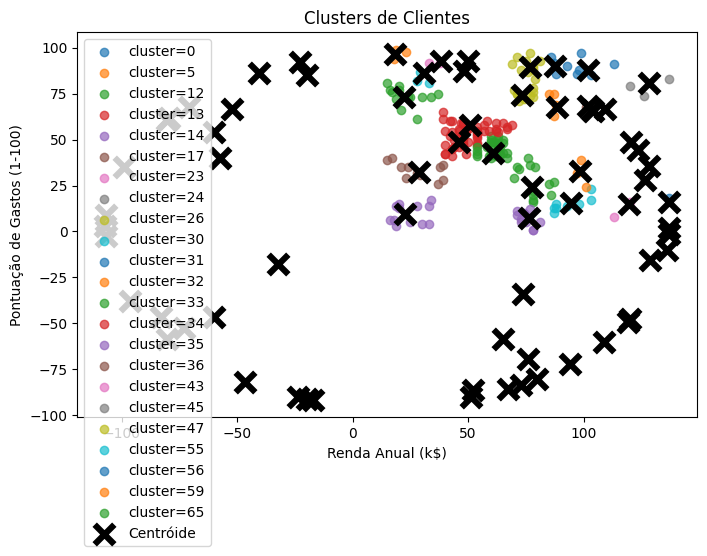

In [77]:
# cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(8,5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotando centróides
for centroid in som.get_weights():
    centroid = scaler.inverse_transform(centroid)
    plt.scatter(centroid[:,0], centroid[:, 1], marker='x', 
                s=10, linewidths=20, color='k', label='Centróide') # label='centróide'
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();
plt.plot()

# Supondo que 'som', 'data_normalized', 'som_shape' e 'scaler' já estejam definidos no seu código

# Cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# Com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Inicializando a lista para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for c in np.unique(cluster_index):
    cluster_points = data[cluster_index == c]
    
    # Determinando o centróide do cluster (média das coordenadas dos pontos)
    centroid = np.mean(cluster_points, axis=0)
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(F_j)
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data, cluster_index, len(np.unique(cluster_index)))

# Printando as métricas
print("Métricas para os clusters SOM:")
print(f"Clusters: {np.unique(cluster_index)}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


Métricas para os clusters SOM:
Clusters: [ 0  5 12 13 14 17 23 24 26 30 31 32 33 34 35 36 43 45 47 55 56 59 65]
F_out (Dispersão inter-cluster): 5.757681686320391
F_in (Dispersão intra-cluster) por cluster: [0.0, 0.0024597045858341495, 0.07597615372008173, 0.0646271348173349, 0.021445066383737957, 0.0001886259527382136, 0.005118285108543109, 0.0, 0.011240712901997681, 0.03430574918256742, 0.006587072842481863, 0.012762605662804698, 0.10163546382045041, 0.159183794992119, 0.06641980729291086, 0.07571442323157672, 0.0008398280032249391, 0.014400970125762679, 0.025998572462056734, 0.003183084215463785, 0.02166888054659738, 0.011061322141225478, 0.07529120407935325]
F_in (Dispersão intra-cluster): 0.790108462068863
Número de pontos por cluster: [1, 3, 11, 22, 10, 2, 2, 1, 10, 8, 4, 3, 31, 28, 12, 11, 2, 3, 11, 3, 5, 4, 13]
Centróides dos clusters: [array([1.        , 0.17708333]), array([0.04098361, 1.        ]), array([0.52384501, 0.25662879]), array([0.25372578, 0.48958333]), array([0.49

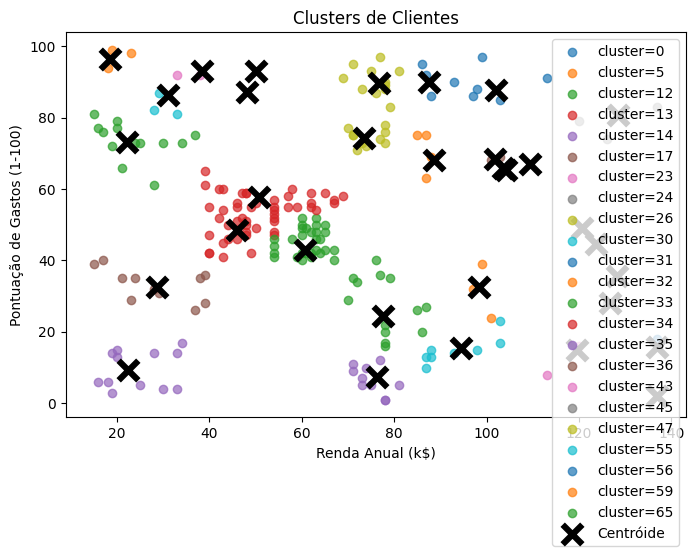

In [78]:
# removendo neuronios não treinados
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(8,5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

i=False
for centroid in som.get_weights()[0]:
    # Filtrando centróides próximos de 0
    if centroid[1] > min(data_normalized[:,1]) and centroid[0] > min(data_normalized[:,0]):  # Verifica se qualquer coordenada é maior que a tolerância
        centroid = scaler.inverse_transform([centroid])[0]
        plt.scatter(centroid[0], centroid[1], marker='x', 
                    s=10, linewidths=20, color='k', label='Centróide' if not i else None) # label='centróide'
        i = True
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();
plt.plot()

# Supondo que 'som', 'data_normalized', 'som_shape' e 'scaler' já estejam definidos no seu código

# Cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# Com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Inicializando a lista para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for c in np.unique(cluster_index):
    cluster_points = data_normalized[cluster_index == c]
    
    # Determinando o centróide do cluster (média das coordenadas dos pontos)
    centroid = np.mean(cluster_points, axis=0)
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(float(F_j))
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data_normalized, cluster_index, len(np.unique(cluster_index)))

# Printando as métricas
print("Métricas para os clusters SOM:")
print(f"Clusters: {np.unique(cluster_index)}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {F_j_values}")
print(f"F_in (Dispersão intra-cluster): {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


In [79]:
import numpy as np

# Função para calcular a distância entre dois pontos (centróides)
def calcular_distancia(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

# Função para decidir se clusters devem ser agrupados ou bipartidos
def verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points ,threshold=2, population_threshold = 5):
    n_clusters = len(centroid_values)
    agrupamentos = []  # Lista para armazenar decisões de agrupamento
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j or (i,j) in agrupamentos:
                continue
            # Calcular a distância entre os centróides dos clusters i e j
            dist = calcular_distancia(centroid_values[i], centroid_values[j])

            sigma_sum = sigma_values[i] + sigma_values[j]
            
            # Comparar a distância entre centróides com a soma das dispersões
            if dist < sigma_sum * threshold:  # Se a distância for muito pequena, agrupar
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[j]))  # Armazenar os pares de clusters que devem ser agrupados
                print(f"Clusters {np.unique(cluster_index)[i]} e {np.unique(cluster_index)[j]} podem ser agrupados. Distância: {dist}, Soma das dispersões: {sigma_sum}")
            elif F_values[i] > F_values[j] and F_values[i] > 10 * F_values[j]:  # Se F_k for muito maior em um cluster
                print(f"Cluster {np.unique(cluster_index)[i]} tem alta dispersão (F_k), considerar bipartição.")
    for i in range(n_clusters):
        if n_cluster_points[i] < population_threshold:
            # Encontrar o cluster mais próximo para agrupar
            min_dist = float('inf')
            closest_cluster = None
            for j in range(n_clusters):
                if i != j and n_cluster_points[j] >= population_threshold:  # Não agrupar com clusters de baixa população
                    dist = calcular_distancia(centroid_values[i], centroid_values[j])
                    if dist < min_dist:
                        min_dist = dist
                        closest_cluster = j
            
            if closest_cluster is not None:
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[closest_cluster]))
                print(f"Cluster {np.unique(cluster_index)[i]} tem população baixa e será agrupado com o cluster {np.unique(cluster_index)[closest_cluster]}. Distância: {min_dist}")

        
    
    return agrupamentos

# Exemplo de centróides, dispersões e sigma (desvio padrão)
centroid_values = centroid_values

# Exemplo de dispersão F (somatória da distância intra-cluster)
F_values = F_j_values

# Exemplo de desvio padrão intra-cluster (σ)
sigma_values = desvio_padrao_intra_values

# Chamando a função para verificar agrupamento e bipartição
agrupamentos = verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points_values, 1.4, 7)

# Se necessário, implementar a lógica de bipartição para clusters com alta dispersão F_k


Cluster 5 tem alta dispersão (F_k), considerar bipartição.
Cluster 5 tem alta dispersão (F_k), considerar bipartição.
Cluster 5 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Clusters 12 e 30 podem ser agrupados. Distância: 0.16228122221965308, Soma das dispersões: 0.14859239179755943
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Clusters 12 e 32 podem ser agrupados. Distância: 0.1762531465594152, Soma das dispersões: 0.1483321432358788
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 13 tem alta dispersão (F_k), considerar bipartição.
Cluster 13 tem alta dispersão (F_k), considerar bipartição.
Clu

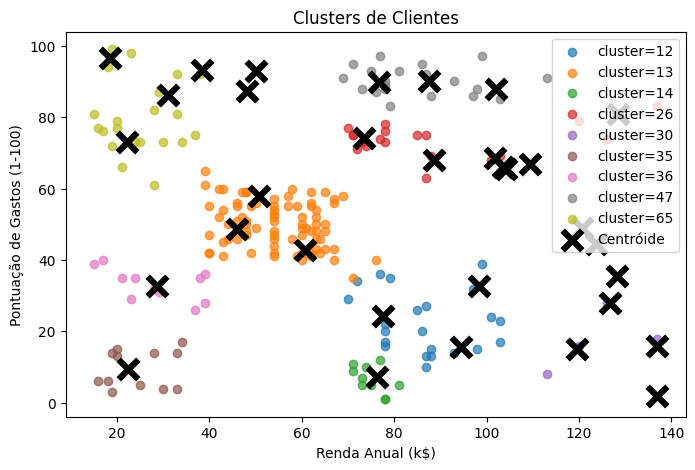

In [80]:
# Agrupando os clusters proximos e com baixa população
for i in agrupamentos:
    cluster_index[cluster_index == i[0]] = i[1]

# Plotando os clusters novamente com os clusters agrupados
plt.figure(figsize=(8, 5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster=' + str(c), alpha=.7)

# Plotando centróides
i = False
for centroid in som.get_weights()[0]:
    if centroid[1] > min(data_normalized[:,1]) and centroid[0] > min(data_normalized[:,0]):
        centroid = scaler.inverse_transform([centroid])[0]
        plt.scatter(centroid[0], centroid[1], marker='x', 
                    s=10, linewidths=20, color='k', label='Centróide' if not i else None)
        i = True

plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();


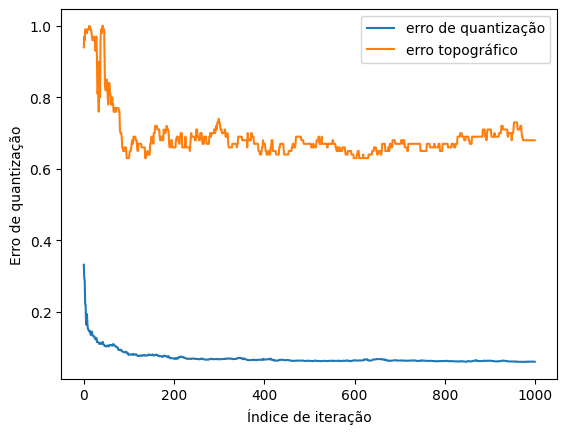

In [82]:
data_normalized, data, n_0 = data_train_normalized, data_train, n_0_train

# Eu uso topografia linear som
som_shape = (1, int(5*np.sqrt(n_0)))

som = MiniSom(som_shape[0], som_shape[1], data_normalized.shape[1], sigma=0.5, learning_rate=0.5)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data_normalized))
    som.update(data_normalized[rand_i], som.winner(data_normalized[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data_normalized))
    t_error.append(som.topographic_error(data_normalized))

plt.plot(np.arange(max_iter), q_error, label='erro de quantização')
plt.plot(np.arange(max_iter), t_error, label='erro topográfico')
plt.ylabel('Erro de quantização')
plt.xlabel('Índice de iteração')
plt.legend()
plt.show()

Métricas para os clusters SOM:
Clusters: [ 1 10 11 12 13 14 16 17 18 25 26 27 36 40 44 48]
F_out (Dispersão inter-cluster): 95457.46948145292
F_in (Dispersão intra-cluster) por cluster: 5312.974801587302
Número de pontos por cluster: [2, 2, 5, 16, 21, 5, 3, 8, 4, 7, 6, 9, 7, 2, 1, 2]
Centróides dos clusters: [array([125.,  87.]), array([108. ,  12.5]), array([95. , 89.4]), array([61.6875, 45.75  ]), array([48.33333333, 52.23809524]), array([24.8,  9.6]), array([89.        , 16.33333333]), array([30.25, 36.5 ]), array([79.75, 34.5 ]), array([76.28571429, 74.85714286]), array([75.16666667,  8.83333333]), array([24.44444444, 75.22222222]), array([78.14285714, 91.85714286]), array([98. , 35.5]), array([18., 94.]), array([131.5,  23. ])]
Máxima distância (diâmetro) por cluster: [25.298221281347036, 13.45362404707371, 15.556349186104045, 15.811388300841896, 25.059928172283335, 17.804493814764857, 9.219544457292887, 26.40075756488817, 17.029386365926403, 16.0, 15.0, 22.80350850198276, 17.4642

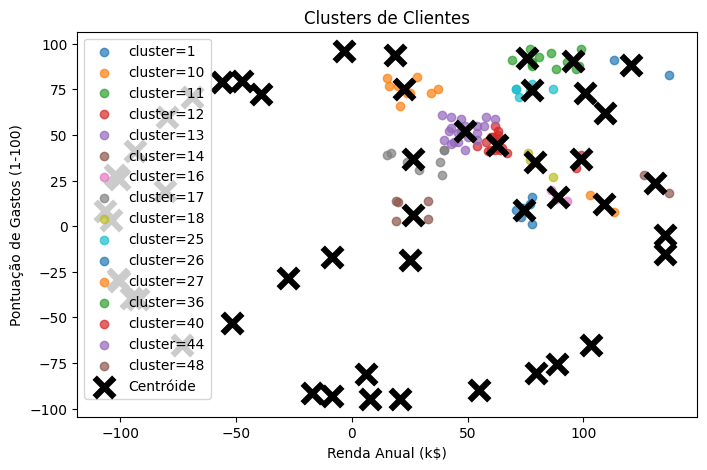

In [83]:
# cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(8,5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotando centróides
for centroid in som.get_weights():
    centroid = scaler.inverse_transform(centroid)
    plt.scatter(centroid[:,0], centroid[:, 1], marker='x', 
                s=10, linewidths=20, color='k', label='Centróide') # label='centróide'
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();
plt.plot()

# Supondo que 'som', 'data_normalized', 'som_shape' e 'scaler' já estejam definidos no seu código

# Cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# Com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Inicializando a lista para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for c in np.unique(cluster_index):
    cluster_points = data[cluster_index == c]
    
    # Determinando o centróide do cluster (média das coordenadas dos pontos)
    centroid = np.mean(cluster_points, axis=0)
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(F_j)
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data, cluster_index, len(np.unique(cluster_index)))

# Printando as métricas
print("Métricas para os clusters SOM:")
print(f"Clusters: {np.unique(cluster_index)}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


Métricas para os clusters SOM:
Clusters: [ 1 10 11 12 13 14 16 17 18 25 26 27 36 40 44 48]
F_out (Dispersão inter-cluster): 8.580178009302351
F_in (Dispersão intra-cluster) por cluster: [0.022821859416524832, 0.0077538432628997565, 0.014537049478933365, 0.040292760542640874, 0.11903183339163255, 0.028688536254441746, 0.00398931909855973, 0.07228522098674192, 0.014679289514840687, 0.016044297461213292, 0.017942191411421168, 0.05065154971076738, 0.017441719602492054, 0.0027927926194048804, 0.0, 0.00949011475783092]
F_in (Dispersão intra-cluster): 0.43844237751034515
Número de pontos por cluster: [2, 2, 5, 16, 21, 5, 3, 8, 4, 7, 6, 9, 7, 2, 1, 2]
Centróides dos clusters: [array([0.90163934, 0.89583333]), array([0.76229508, 0.11979167]), array([0.6557377 , 0.92083333]), array([0.38268443, 0.46614583]), array([0.27322404, 0.53373016]), array([0.08032787, 0.08958333]), array([0.60655738, 0.15972222]), array([0.125     , 0.36979167]), array([0.5307377 , 0.34895833]), array([0.50234192, 0.7693

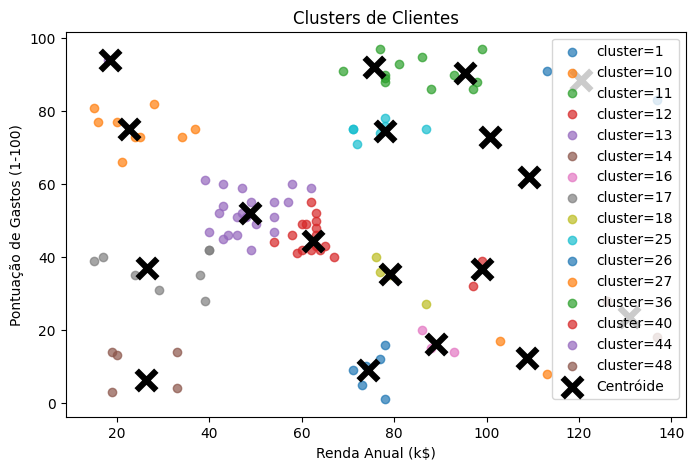

In [84]:
# removendo neuronios não treinados
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(8,5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

i=False
for centroid in som.get_weights()[0]:
    # Filtrando centróides próximos de 0
    if centroid[1] > min(data_normalized[:,1]) and centroid[0] > min(data_normalized[:,0]):  # Verifica se qualquer coordenada é maior que a tolerância
        centroid = scaler.inverse_transform([centroid])[0]
        plt.scatter(centroid[0], centroid[1], marker='x', 
                    s=10, linewidths=20, color='k', label='Centróide' if not i else None) # label='centróide'
        i = True
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();
plt.plot()

# Supondo que 'som', 'data_normalized', 'som_shape' e 'scaler' já estejam definidos no seu código

# Cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# Com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Inicializando a lista para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for c in np.unique(cluster_index):
    cluster_points = data_normalized[cluster_index == c]
    
    # Determinando o centróide do cluster (média das coordenadas dos pontos)
    centroid = np.mean(cluster_points, axis=0)
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(float(F_j))
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data_normalized, cluster_index, len(np.unique(cluster_index)))

# Printando as métricas
print("Métricas para os clusters SOM:")
print(f"Clusters: {np.unique(cluster_index)}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {F_j_values}")
print(f"F_in (Dispersão intra-cluster): {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


In [85]:
import numpy as np

# Função para calcular a distância entre dois pontos (centróides)
def calcular_distancia(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

# Função para decidir se clusters devem ser agrupados ou bipartidos
def verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points ,threshold=2, population_threshold = 5):
    n_clusters = len(centroid_values)
    agrupamentos = []  # Lista para armazenar decisões de agrupamento
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j or (i,j) in agrupamentos:
                continue
            # Calcular a distância entre os centróides dos clusters i e j
            dist = calcular_distancia(centroid_values[i], centroid_values[j])

            sigma_sum = sigma_values[i] + sigma_values[j]
            
            # Comparar a distância entre centróides com a soma das dispersões
            if dist < sigma_sum * threshold:  # Se a distância for muito pequena, agrupar
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[j]))  # Armazenar os pares de clusters que devem ser agrupados
                print(f"Clusters {np.unique(cluster_index)[i]} e {np.unique(cluster_index)[j]} podem ser agrupados. Distância: {dist}, Soma das dispersões: {sigma_sum}")
            elif F_values[i] > F_values[j] and F_values[i] > 10 * F_values[j]:  # Se F_k for muito maior em um cluster
                print(f"Cluster {np.unique(cluster_index)[i]} tem alta dispersão (F_k), considerar bipartição.")
    for i in range(n_clusters):
        if n_cluster_points[i] < population_threshold:
            # Encontrar o cluster mais próximo para agrupar
            min_dist = float('inf')
            closest_cluster = None
            for j in range(n_clusters):
                if i != j and n_cluster_points[j] >= population_threshold:  # Não agrupar com clusters de baixa população
                    dist = calcular_distancia(centroid_values[i], centroid_values[j])
                    if dist < min_dist:
                        min_dist = dist
                        closest_cluster = j
            
            if closest_cluster is not None:
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[closest_cluster]))
                print(f"Cluster {np.unique(cluster_index)[i]} tem população baixa e será agrupado com o cluster {np.unique(cluster_index)[closest_cluster]}. Distância: {min_dist}")

        
    
    return agrupamentos

# Exemplo de centróides, dispersões e sigma (desvio padrão)
centroid_values = centroid_values

# Exemplo de dispersão F (somatória da distância intra-cluster)
F_values = F_j_values

# Exemplo de desvio padrão intra-cluster (σ)
sigma_values = desvio_padrao_intra_values

# Chamando a função para verificar agrupamento e bipartição
agrupamentos = verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points_values, 1.4, 7)

# Se necessário, implementar a lógica de bipartição para clusters com alta dispersão F_k


Cluster 1 tem alta dispersão (F_k), considerar bipartição.
Cluster 10 tem alta dispersão (F_k), considerar bipartição.
Clusters 11 e 36 podem ser agrupados. Distância: 0.1405239396989194, Soma das dispersões: 0.10383707618993589
Cluster 11 tem alta dispersão (F_k), considerar bipartição.
Clusters 12 e 13 podem ser agrupados. Distância: 0.12864375763860836, Soma das dispersões: 0.12546997497291507
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 12 tem alta dispersão (F_k), considerar bipartição.
Cluster 13 tem alta dispersão (F_k), considerar bipartição.
Clusters 13 e 12 podem ser agrupados. Distância: 0.12864375763860836, Soma das dispersões: 0.12546997497291507
Cluster 13 tem alta dispersão (F_k), considerar bipartição.
Clusters 13 e 17 podem ser agrupados. Distância: 0.22101175605729428, Soma das dispersões: 0.1703433831178386
Cluster 13 tem alta dispersão (F_k), considerar bipartição.
Cluster 13 tem alta

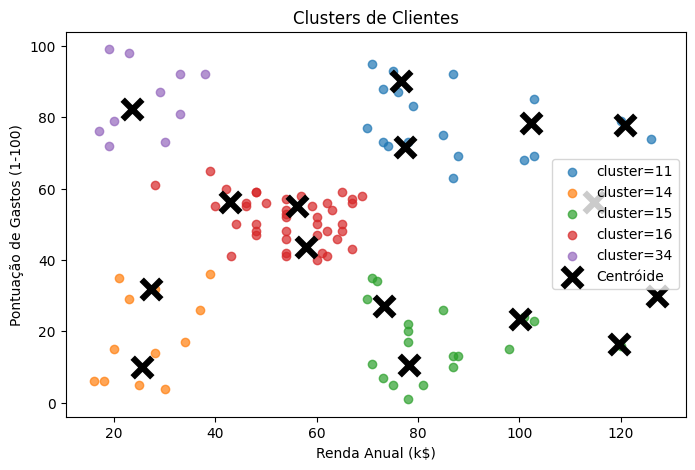

In [75]:
# Agrupando os clusters proximos e com baixa população
for i in agrupamentos:
    cluster_index[cluster_index == i[0]] = i[1]

# Plotando os clusters novamente com os clusters agrupados
plt.figure(figsize=(8, 5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster=' + str(c), alpha=.7)

# Plotando centróides
i = False
for centroid in som.get_weights()[0]:
    if centroid[1] > min(data_normalized[:,1]) and centroid[0] > min(data_normalized[:,0]):
        centroid = scaler.inverse_transform([centroid])[0]
        plt.scatter(centroid[0], centroid[1], marker='x', 
                    s=10, linewidths=20, color='k', label='Centróide' if not i else None)
        i = True

plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();


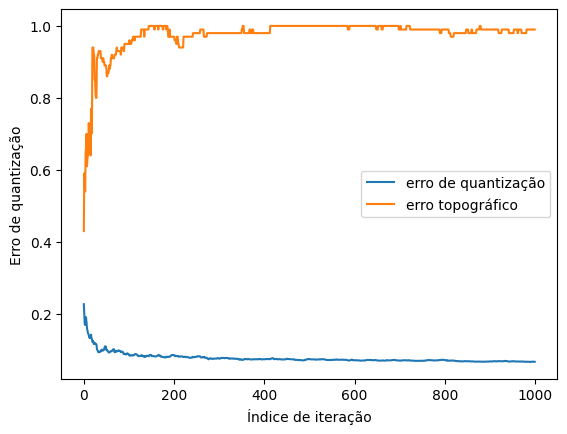

In [71]:
data_normalized, data, n_0 = data_val_normalized, data_val, n_0_val

# Eu uso topografia linear som
som_shape = (1, int(5*np.sqrt(n_0)))

som = MiniSom(som_shape[0], som_shape[1], data_normalized.shape[1], sigma=0.5, learning_rate=0.5)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data_normalized))
    som.update(data_normalized[rand_i], som.winner(data_normalized[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data_normalized))
    t_error.append(som.topographic_error(data_normalized))

plt.plot(np.arange(max_iter), q_error, label='erro de quantização')
plt.plot(np.arange(max_iter), t_error, label='erro topográfico')
plt.ylabel('Erro de quantização')
plt.xlabel('Índice de iteração')
plt.legend()
plt.show()

Métricas para os clusters SOM:
Clusters: [ 0  1 11 14 15 16 19 28 29 30 31 34 35 47]
F_out (Dispersão inter-cluster): 38061.461125365
F_in (Dispersão intra-cluster) por cluster: 6079.917658730158
Número de pontos por cluster: [1, 6, 7, 7, 9, 10, 3, 6, 15, 5, 16, 10, 3, 2]
Centróides dos clusters: [array([120.,  16.]), array([76.83333333, 89.66666667]), array([79.28571429, 71.71428571]), array([24.42857143,  9.57142857]), array([79.77777778,  9.11111111]), array([42.9, 57. ]), array([100.66666667,  20.66666667]), array([75.66666667, 27.66666667]), array([59.66666667, 55.13333333]), array([29.6, 31.6]), array([57.5625, 44.875 ]), array([26.1, 84.9]), array([102.33333333,  74.        ]), array([123. ,  76.5])]
Máxima distância (diâmetro) por cluster: [0.0, 16.278820596099706, 22.02271554554524, 21.095023109728988, 17.11724276862369, 22.825424421026653, 9.486832980505138, 16.64331697709324, 19.1049731745428, 18.35755975068582, 24.08318915758459, 28.231188426986208, 17.11724276862369, 7.810

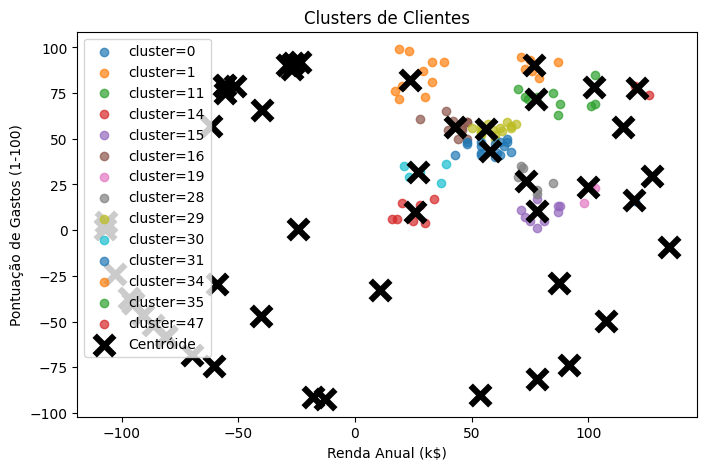

In [72]:
# cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(8,5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plotando centróides
for centroid in som.get_weights():
    centroid = scaler.inverse_transform(centroid)
    plt.scatter(centroid[:,0], centroid[:, 1], marker='x', 
                s=10, linewidths=20, color='k', label='Centróide') # label='centróide'
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();
plt.plot()

# Supondo que 'som', 'data_normalized', 'som_shape' e 'scaler' já estejam definidos no seu código

# Cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# Com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Inicializando a lista para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for c in np.unique(cluster_index):
    cluster_points = data[cluster_index == c]
    
    # Determinando o centróide do cluster (média das coordenadas dos pontos)
    centroid = np.mean(cluster_points, axis=0)
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(F_j)
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data, cluster_index, len(np.unique(cluster_index)))

# Printando as métricas
print("Métricas para os clusters SOM:")
print(f"Clusters: {np.unique(cluster_index)}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


Métricas para os clusters SOM:
Clusters: [ 0  1 11 14 15 16 19 28 29 30 31 34 35 47]
F_out (Dispersão inter-cluster): 3.4339269839807454
F_in (Dispersão intra-cluster) por cluster: [0.0, 0.021584143456309043, 0.03533982073804616, 0.03770397822525946, 0.043670693279053485, 0.0453079509316492, 0.006131697006230902, 0.03165210653747, 0.041703459687011675, 0.025192098991459886, 0.06837050709514693, 0.13203771492598307, 0.01992742719624354, 0.002565689130199468]
F_in (Dispersão intra-cluster): 0.5111872872000628
Número de pontos por cluster: [1, 6, 7, 7, 9, 10, 3, 6, 15, 5, 16, 10, 3, 2]
Centróides dos clusters: [array([0.86065574, 0.15625   ]), array([0.5068306 , 0.92361111]), array([0.52693208, 0.73660714]), array([0.07728337, 0.08928571]), array([0.53096539, 0.08449074]), array([0.22868852, 0.58333333]), array([0.70218579, 0.20486111]), array([0.49726776, 0.27777778]), array([0.36612022, 0.56388889]), array([0.11967213, 0.31875   ]), array([0.34887295, 0.45703125]), array([0.09098361, 0.

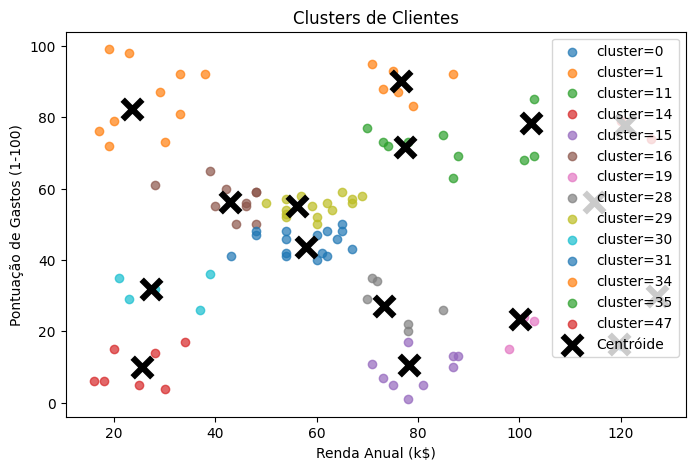

In [73]:
# removendo neuronios não treinados
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plotando os clusters 
plt.figure(figsize=(8,5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

i=False
for centroid in som.get_weights()[0]:
    # Filtrando centróides próximos de 0
    if centroid[1] > min(data_normalized[:,1]) and centroid[0] > min(data_normalized[:,0]):  # Verifica se qualquer coordenada é maior que a tolerância
        centroid = scaler.inverse_transform([centroid])[0]
        plt.scatter(centroid[0], centroid[1], marker='x', 
                    s=10, linewidths=20, color='k', label='Centróide' if not i else None) # label='centróide'
        i = True
    
plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();
plt.plot()

# Supondo que 'som', 'data_normalized', 'som_shape' e 'scaler' já estejam definidos no seu código

# Cada neurônio representa um cluster
winner_coordinates = np.array([som.winner(x) for x in data_normalized]).T

# Com np.ravel_multi_index, convertemos as coordenadas bidimensionais
# em um índice monodimensional
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Inicializando a lista para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for c in np.unique(cluster_index):
    cluster_points = data_normalized[cluster_index == c]
    
    # Determinando o centróide do cluster (média das coordenadas dos pontos)
    centroid = np.mean(cluster_points, axis=0)
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(float(F_j))
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data_normalized, cluster_index, len(np.unique(cluster_index)))

# Printando as métricas
print("Métricas para os clusters SOM:")
print(f"Clusters: {np.unique(cluster_index)}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {F_j_values}")
print(f"F_in (Dispersão intra-cluster): {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


In [74]:
import numpy as np

# Função para calcular a distância entre dois pontos (centróides)
def calcular_distancia(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

# Função para decidir se clusters devem ser agrupados ou bipartidos
def verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points ,threshold=2, population_threshold = 5):
    n_clusters = len(centroid_values)
    agrupamentos = []  # Lista para armazenar decisões de agrupamento
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j or (i,j) in agrupamentos:
                continue
            # Calcular a distância entre os centróides dos clusters i e j
            dist = calcular_distancia(centroid_values[i], centroid_values[j])

            sigma_sum = sigma_values[i] + sigma_values[j]
            
            # Comparar a distância entre centróides com a soma das dispersões
            if dist < sigma_sum * threshold:  # Se a distância for muito pequena, agrupar
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[j]))  # Armazenar os pares de clusters que devem ser agrupados
                print(f"Clusters {np.unique(cluster_index)[i]} e {np.unique(cluster_index)[j]} podem ser agrupados. Distância: {dist}, Soma das dispersões: {sigma_sum}")
            elif F_values[i] > F_values[j] and F_values[i] > 10 * F_values[j]:  # Se F_k for muito maior em um cluster
                print(f"Cluster {np.unique(cluster_index)[i]} tem alta dispersão (F_k), considerar bipartição.")
    for i in range(n_clusters):
        if n_cluster_points[i] < population_threshold:
            # Encontrar o cluster mais próximo para agrupar
            min_dist = float('inf')
            closest_cluster = None
            for j in range(n_clusters):
                if i != j and n_cluster_points[j] >= population_threshold:  # Não agrupar com clusters de baixa população
                    dist = calcular_distancia(centroid_values[i], centroid_values[j])
                    if dist < min_dist:
                        min_dist = dist
                        closest_cluster = j
            
            if closest_cluster is not None:
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[closest_cluster]))
                print(f"Cluster {np.unique(cluster_index)[i]} tem população baixa e será agrupado com o cluster {np.unique(cluster_index)[closest_cluster]}. Distância: {min_dist}")

        
    
    return agrupamentos

# Exemplo de centróides, dispersões e sigma (desvio padrão)
centroid_values = centroid_values

# Exemplo de dispersão F (somatória da distância intra-cluster)
F_values = F_j_values

# Exemplo de desvio padrão intra-cluster (σ)
sigma_values = desvio_padrao_intra_values

# Chamando a função para verificar agrupamento e bipartição
agrupamentos = verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points_values, 1.4, 7)

# Se necessário, implementar a lógica de bipartição para clusters com alta dispersão F_k


Cluster 1 tem alta dispersão (F_k), considerar bipartição.
Cluster 11 tem alta dispersão (F_k), considerar bipartição.
Clusters 11 e 35 podem ser agrupados. Distância: 0.1904093924413384, Soma das dispersões: 0.15255450455197941
Cluster 11 tem alta dispersão (F_k), considerar bipartição.
Cluster 14 tem alta dispersão (F_k), considerar bipartição.
Cluster 14 tem alta dispersão (F_k), considerar bipartição.
Cluster 15 tem alta dispersão (F_k), considerar bipartição.
Clusters 15 e 28 podem ser agrupados. Distância: 0.19620246964014665, Soma das dispersões: 0.14229005929785124
Cluster 15 tem alta dispersão (F_k), considerar bipartição.
Cluster 16 tem alta dispersão (F_k), considerar bipartição.
Clusters 16 e 29 podem ser agrupados. Distância: 0.13880042122579736, Soma das dispersões: 0.12003907352519456
Clusters 16 e 31 podem ser agrupados. Distância: 0.17434595654174598, Soma das dispersões: 0.13268056755698654
Cluster 16 tem alta dispersão (F_k), considerar bipartição.
Cluster 19 tem alt

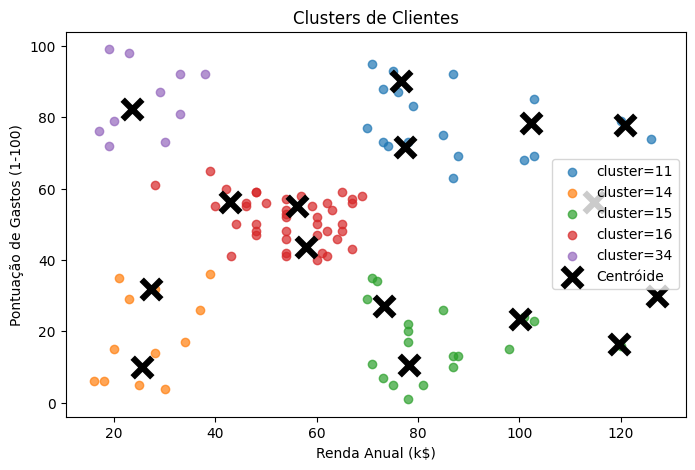

In [75]:
# Agrupando os clusters proximos e com baixa população
for i in agrupamentos:
    cluster_index[cluster_index == i[0]] = i[1]

# Plotando os clusters novamente com os clusters agrupados
plt.figure(figsize=(8, 5))

for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster=' + str(c), alpha=.7)

# Plotando centróides
i = False
for centroid in som.get_weights()[0]:
    if centroid[1] > min(data_normalized[:,1]) and centroid[0] > min(data_normalized[:,0]):
        centroid = scaler.inverse_transform([centroid])[0]
        plt.scatter(centroid[0], centroid[1], marker='x', 
                    s=10, linewidths=20, color='k', label='Centróide' if not i else None)
        i = True

plt.title("Clusters de Clientes")
plt.xlabel("Renda Anual (k$)")
plt.ylabel("Pontuação de Gastos (1-100)")
plt.legend();


## ART

In [86]:
import numpy as np

class ART2:
    def __init__(self, input_dim, num_clusters, vigilance=0.9, learning_rate=0.5):
        self.input_dim = input_dim
        self.num_clusters = num_clusters
        self.vigilance = vigilance
        self.learning_rate = learning_rate
        
        # Inicializar pesos com valores aleatórios
        self.weights = np.random.rand(num_clusters, input_dim)
    
    def normalize(self, vector):
        return vector / (np.linalg.norm(vector) + 1e-9)
    
    def match(self, input_vector, cluster_idx):
        cluster_vector = self.weights[cluster_idx]
        return np.dot(input_vector, cluster_vector) / np.linalg.norm(cluster_vector)
    
    def train(self, data):
        for input_vector in data:
            input_vector = self.normalize(input_vector)
            
            # Testar similaridade com os clusters existentes
            for cluster_idx in range(self.num_clusters):
                similarity = self.match(input_vector, cluster_idx)
                if similarity >= self.vigilance:
                    # Atualizar os pesos do cluster
                    self.weights[cluster_idx] += self.learning_rate * (input_vector - self.weights[cluster_idx])
                    self.weights[cluster_idx] = self.normalize(self.weights[cluster_idx])
                    break
            else:
                print("Nenhum cluster correspondeu ao critério de vigilância.")
    
    def predict(self, data):
        predictions = []
        for input_vector in data:
            input_vector = self.normalize(input_vector)
            similarities = [self.match(input_vector, cluster_idx) for cluster_idx in range(self.num_clusters)]
            predictions.append(np.argmax(similarities))
        return predictions

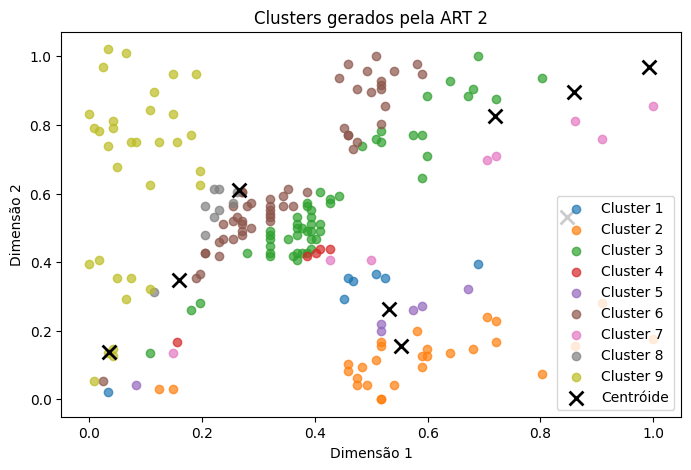

Métricas para os clusters ART:
Clusters: [0 1 2 3 4 5 6 7 8]
F_out (Dispersão inter-cluster): 0.5946543841483772
F_in (Dispersão intra-cluster) por cluster: [3.2291574008318977, 4.553711859331308, 21.22393477792126, 3.616092406595679, 0.8674140090443314, 19.130710992733324, 4.0439944683579405, 0.8352542098916497, 16.965273376817002]
F_in (Dispersão intra-cluster): 74.4655435015244
Número de pontos por cluster: [7, 28, 52, 5, 6, 52, 8, 9, 33]
Centróides dos clusters: [array([0.84719486, 0.53128228]), array([0.55289955, 0.15476404]), array([0.71966189, 0.82466555]), array([0.86015957, 0.895324  ]), array([0.53209518, 0.26259759]), array([0.15956849, 0.34750565]), array([0.99297927, 0.96792409]), array([0.26453453, 0.6101881 ]), array([0.03431915, 0.13869884])]
Máxima distância (diâmetro) por cluster: [0.7553919099720151, 0.8890908985165115, 1.0624303551175136, 0.3827747511074903, 0.6537545655652791, 1.0817359575688579, 1.1150282225712835, 0.3268604997365618, 0.9690620406673258]
Variância

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Função para calcular a dispersão intra-cluster F_j
def calcular_dispersaointra(cluster_points, centroid):
    return np.sum(np.linalg.norm(cluster_points - centroid, axis=1))

# Função para calcular o diâmetro máximo do cluster
def calcular_diametro(cluster_points):
    distancias = [np.linalg.norm(point1 - point2) 
                  for i, point1 in enumerate(cluster_points) 
                  for j, point2 in enumerate(cluster_points) if i != j]
    return np.max(distancias)

# Função para calcular a variância intra-cluster
def calcular_variancia_intra(cluster_points, centroid):
    return np.var(np.linalg.norm(cluster_points - centroid, axis=1))

# Função para calcular o desvio padrão intra-cluster
def calcular_desvio_padrao_intra(variancia_intra):
    return np.sqrt(variancia_intra)

# Função para calcular a dispersão inter-cluster (F_out)
def calcular_dispersaointer(centroid_values, data_normalized, cluster_index, n_clusters):
    F_out_values = []
    for i in range(n_clusters):
        centroid_i = centroid_values[i]
        distancias = [np.linalg.norm(centroid_i - centroid_values[j]) for j in range(n_clusters) if i != j]
        F_out_values.append(np.mean(distancias))
    return np.mean(F_out_values)

data_normalized, data, n_0 = data_all_normalized, data_all, n_0_all
# Inicializando o ART2 com 2 dimensões e 5 clusters
art2 = ART2(input_dim=2, num_clusters=9, vigilance=0.3, learning_rate=0.6)
art2.train(data_normalized)
cluster_assignments = art2.predict(data_normalized)  # Clusters atribuídos

# Plotando os clusters
plt.figure(figsize=(8, 5))

unique_clusters = np.unique(cluster_assignments)
for cluster in unique_clusters:
    cluster_data = data_normalized[np.array(cluster_assignments) == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                label=f'Cluster {cluster + 1}', alpha=0.7)

# Plotando centróides (os pesos dos clusters)
centroids = art2.weights
plt.scatter(centroids[:,0], centroids[:,1], marker='x', 
            s=100, linewidths=2, color='k', label='Centróide')

plt.title("Clusters gerados pela ART 2")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend()
plt.show()

# Inicializando as listas para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for cluster in unique_clusters:
    cluster_points = data_normalized[cluster_assignments == cluster]
    
    # Determinando o centróide do cluster (peso do cluster)
    centroid = art2.weights[cluster]
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(float(F_j))
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data_normalized, cluster_assignments, len(unique_clusters))

# Printando as métricas
print("Métricas para os clusters ART:")
print(f"Clusters: {unique_clusters}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {F_j_values}")
print(f"F_in (Dispersão intra-cluster): {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


In [88]:
import numpy as np
cluster_index = [i+1 for i in cluster_assignments]
# Função para calcular a distância entre dois pontos (centróides)
def calcular_distancia(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

# Função para decidir se clusters devem ser agrupados ou bipartidos
def verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points ,threshold=2, population_threshold = 5):
    n_clusters = len(centroid_values)
    agrupamentos = []  # Lista para armazenar decisões de agrupamento
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j or (i,j) in agrupamentos:
                continue
            # Calcular a distância entre os centróides dos clusters i e j
            dist = calcular_distancia(centroid_values[i], centroid_values[j])

            sigma_sum = sigma_values[i] + sigma_values[j]
            
            # Comparar a distância entre centróides com a soma das dispersões
            if dist < sigma_sum * threshold:  # Se a distância for muito pequena, agrupar
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[j]))  # Armazenar os pares de clusters que devem ser agrupados
                print(f"Clusters {np.unique(cluster_index)[i]} e {np.unique(cluster_index)[j]} podem ser agrupados. Distância: {dist}, Soma das dispersões: {sigma_sum}")
            elif F_values[i] > F_values[j] and F_values[i] > 10 * F_values[j]:  # Se F_k for muito maior em um cluster
                print(f"Cluster {np.unique(cluster_index)[i]} tem alta dispersão (F_k), considerar bipartição.")
    for i in range(n_clusters):
        if n_cluster_points[i] < population_threshold:
            # Encontrar o cluster mais próximo para agrupar
            min_dist = float('inf')
            closest_cluster = None
            for j in range(n_clusters):
                if i != j and n_cluster_points[j] >= population_threshold:  # Não agrupar com clusters de baixa população
                    dist = calcular_distancia(centroid_values[i], centroid_values[j])
                    if dist < min_dist:
                        min_dist = dist
                        closest_cluster = j
            
            if closest_cluster is not None:
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[closest_cluster]))
                print(f"Cluster {np.unique(cluster_index)[i]} tem população baixa e será agrupado com o cluster {np.unique(cluster_index)[closest_cluster]}. Distância: {min_dist}")

        
    
    return agrupamentos

# Exemplo de centróides, dispersões e sigma (desvio padrão)
centroid_values = centroid_values

# Exemplo de dispersão F (somatória da distância intra-cluster)
F_values = F_j_values

# Exemplo de desvio padrão intra-cluster (σ)
sigma_values = desvio_padrao_intra_values

# Chamando a função para verificar agrupamento e bipartição
agrupamentos = verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points_values, 1.5, 9)

# Se necessário, implementar a lógica de bipartição para clusters com alta dispersão F_k


Clusters 1 e 2 podem ser agrupados. Distância: 0.4778867178421696, Soma das dispersões: 0.3420828764450098
Clusters 1 e 3 podem ser agrupados. Distância: 0.3199037461315603, Soma das dispersões: 0.4039240054490697
Clusters 1 e 4 podem ser agrupados. Distância: 0.3642725091166518, Soma das dispersões: 0.36363111596430503
Clusters 1 e 5 podem ser agrupados. Distância: 0.41410055916317967, Soma das dispersões: 0.3816146092884304
Clusters 1 e 7 podem ser agrupados. Distância: 0.46033592711335863, Soma das dispersões: 0.5642770181327876
Clusters 2 e 1 podem ser agrupados. Distância: 0.4778867178421696, Soma das dispersões: 0.3420828764450098
Clusters 2 e 9 podem ser agrupados. Distância: 0.5188291865233315, Soma das dispersões: 0.39077050958092885
Clusters 3 e 1 podem ser agrupados. Distância: 0.3199037461315603, Soma das dispersões: 0.4039240054490697
Clusters 3 e 4 podem ser agrupados. Distância: 0.1572647885961067, Soma das dispersões: 0.3319981613505383
Cluster 3 tem alta dispersão (F_k

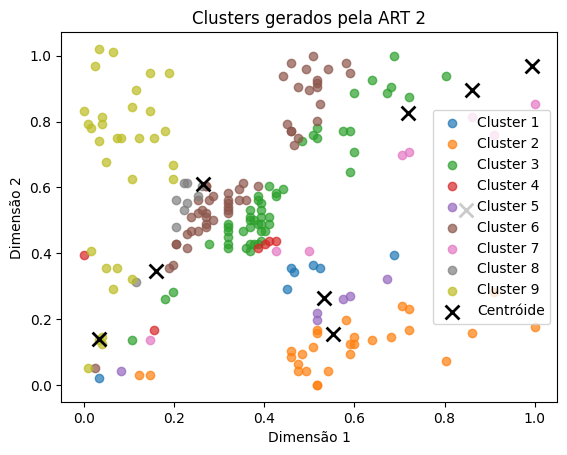

In [89]:
for (i, j) in agrupamentos:
        # Atualizar o índice de cluster para todos os pontos nos clusters i e j
        cluster_assignments[cluster_assignments == int(i)] = j

unique_clusters = np.unique(cluster_assignments)
for cluster in unique_clusters:
    cluster_data = data_normalized[np.array(cluster_assignments) == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                label=f'Cluster {cluster + 1}', alpha=0.7)

# Plotando centróides (os pesos dos clusters)
centroids = art2.weights
plt.scatter(centroids[:,0], centroids[:,1], marker='x', 
            s=100, linewidths=2, color='k', label='Centróide')

plt.title("Clusters gerados pela ART 2")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend()
plt.show()

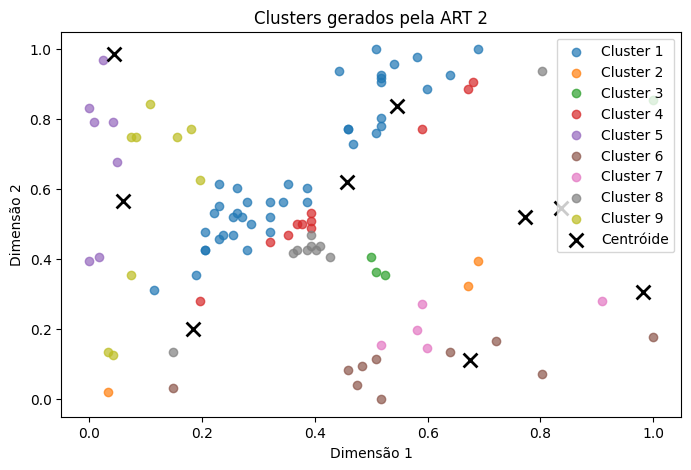

Métricas para os clusters ART:
Clusters: [0 1 2 3 4 5 6 7 8]
F_out (Dispersão inter-cluster): 0.585094167663231
F_in (Dispersão intra-cluster) por cluster: [12.679409888224093, 1.4511374753866573, 1.3057041957395323, 2.4110435975541855, 2.055249486593049, 2.0977615666968763, 1.7926456865193914, 3.532338093848856, 2.334351718193027]
F_in (Dispersão intra-cluster): 29.659641708755668
Número de pontos por cluster: [41, 3, 4, 11, 7, 10, 5, 10, 9]
Centróides dos clusters: [array([0.54495286, 0.83846668]), array([0.83740349, 0.54658521]), array([0.77329158, 0.51944578]), array([0.45731623, 0.61978457]), array([0.04342725, 0.98570094]), array([0.67538455, 0.11228591]), array([0.98268929, 0.30632522]), array([0.1828992 , 0.20077532]), array([0.05923665, 0.56496716])]
Máxima distância (diâmetro) por cluster: [0.8954712877944084, 0.7553919099720151, 0.6939469037372819, 0.7902533152971148, 0.573444141226298, 0.864843185636325, 0.41282211369356275, 1.0360162215246826, 0.7217350496383778]
Variância

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Função para calcular a dispersão intra-cluster F_j
def calcular_dispersaointra(cluster_points, centroid):
    return np.sum(np.linalg.norm(cluster_points - centroid, axis=1))

# Função para calcular o diâmetro máximo do cluster
def calcular_diametro(cluster_points):
    distancias = [np.linalg.norm(point1 - point2) 
                  for i, point1 in enumerate(cluster_points) 
                  for j, point2 in enumerate(cluster_points) if i != j]
    return np.max(distancias)

# Função para calcular a variância intra-cluster
def calcular_variancia_intra(cluster_points, centroid):
    return np.var(np.linalg.norm(cluster_points - centroid, axis=1))

# Função para calcular o desvio padrão intra-cluster
def calcular_desvio_padrao_intra(variancia_intra):
    return np.sqrt(variancia_intra)

# Função para calcular a dispersão inter-cluster (F_out)
def calcular_dispersaointer(centroid_values, data_normalized, cluster_index, n_clusters):
    F_out_values = []
    for i in range(n_clusters):
        centroid_i = centroid_values[i]
        distancias = [np.linalg.norm(centroid_i - centroid_values[j]) for j in range(n_clusters) if i != j]
        F_out_values.append(np.mean(distancias))
    return np.mean(F_out_values)

data_normalized, data, n_0 = data_train_normalized, data_train, n_0_train
# Inicializando o ART2 com 2 dimensões e 5 clusters
art2 = ART2(input_dim=2, num_clusters=9, vigilance=0.3, learning_rate=0.6)
art2.train(data_normalized)
cluster_assignments = art2.predict(data_normalized)  # Clusters atribuídos

# Plotando os clusters
plt.figure(figsize=(8, 5))

unique_clusters = np.unique(cluster_assignments)
for cluster in unique_clusters:
    cluster_data = data_normalized[np.array(cluster_assignments) == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                label=f'Cluster {cluster + 1}', alpha=0.7)

# Plotando centróides (os pesos dos clusters)
centroids = art2.weights
plt.scatter(centroids[:,0], centroids[:,1], marker='x', 
            s=100, linewidths=2, color='k', label='Centróide')

plt.title("Clusters gerados pela ART 2")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend()
plt.show()

# Inicializando as listas para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for cluster in unique_clusters:
    cluster_points = data_normalized[cluster_assignments == cluster]
    
    # Determinando o centróide do cluster (peso do cluster)
    centroid = art2.weights[cluster]
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(float(F_j))
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data_normalized, cluster_assignments, len(unique_clusters))

# Printando as métricas
print("Métricas para os clusters ART:")
print(f"Clusters: {unique_clusters}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {F_j_values}")
print(f"F_in (Dispersão intra-cluster): {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


In [94]:
import numpy as np
cluster_index = [i+1 for i in cluster_assignments]
# Função para calcular a distância entre dois pontos (centróides)
def calcular_distancia(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

# Função para decidir se clusters devem ser agrupados ou bipartidos
def verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points ,threshold=2, population_threshold = 5):
    n_clusters = len(centroid_values)
    agrupamentos = []  # Lista para armazenar decisões de agrupamento
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j or (i,j) in agrupamentos:
                continue
            # Calcular a distância entre os centróides dos clusters i e j
            dist = calcular_distancia(centroid_values[i], centroid_values[j])

            sigma_sum = sigma_values[i] + sigma_values[j]
            
            # Comparar a distância entre centróides com a soma das dispersões
            if dist < sigma_sum * threshold:  # Se a distância for muito pequena, agrupar
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[j]))  # Armazenar os pares de clusters que devem ser agrupados
                print(f"Clusters {np.unique(cluster_index)[i]} e {np.unique(cluster_index)[j]} podem ser agrupados. Distância: {dist}, Soma das dispersões: {sigma_sum}")
            elif F_values[i] > F_values[j] and F_values[i] > 10 * F_values[j]:  # Se F_k for muito maior em um cluster
                print(f"Cluster {np.unique(cluster_index)[i]} tem alta dispersão (F_k), considerar bipartição.")
    for i in range(n_clusters):
        if n_cluster_points[i] < population_threshold:
            # Encontrar o cluster mais próximo para agrupar
            min_dist = float('inf')
            closest_cluster = None
            for j in range(n_clusters):
                if i != j and n_cluster_points[j] >= population_threshold:  # Não agrupar com clusters de baixa população
                    dist = calcular_distancia(centroid_values[i], centroid_values[j])
                    if dist < min_dist:
                        min_dist = dist
                        closest_cluster = j
            
            if closest_cluster is not None:
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[closest_cluster]))
                print(f"Cluster {np.unique(cluster_index)[i]} tem população baixa e será agrupado com o cluster {np.unique(cluster_index)[closest_cluster]}. Distância: {min_dist}")

        
    
    return agrupamentos

# Exemplo de centróides, dispersões e sigma (desvio padrão)
centroid_values = centroid_values

# Exemplo de dispersão F (somatória da distância intra-cluster)
F_values = F_j_values

# Exemplo de desvio padrão intra-cluster (σ)
sigma_values = desvio_padrao_intra_values

# Chamando a função para verificar agrupamento e bipartição
agrupamentos = verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points_values, 1.5, 9)

# Se necessário, implementar a lógica de bipartição para clusters com alta dispersão F_k


Clusters 1 e 2 podem ser agrupados. Distância: 0.41318539430735607, Soma das dispersões: 0.5136300586074536
Clusters 1 e 4 podem ser agrupados. Distância: 0.235588724903138, Soma das dispersões: 0.27819355985344246
Clusters 1 e 5 podem ser agrupados. Distância: 0.5226909859989498, Soma das dispersões: 0.3751074868322436
Clusters 2 e 1 podem ser agrupados. Distância: 0.41318539430735607, Soma das dispersões: 0.5136300586074536
Clusters 2 e 4 podem ser agrupados. Distância: 0.38707166320666403, Soma das dispersões: 0.44193411540893435
Clusters 2 e 7 podem ser agrupados. Distância: 0.2807718348174575, Soma das dispersões: 0.48312047711358014
Clusters 2 e 8 podem ser agrupados. Distância: 0.7402434375699615, Soma das dispersões: 0.5545814863366519
Clusters 4 e 1 podem ser agrupados. Distância: 0.235588724903138, Soma das dispersões: 0.27819355985344246
Clusters 4 e 2 podem ser agrupados. Distância: 0.38707166320666403, Soma das dispersões: 0.44193411540893435
Clusters 5 e 1 podem ser agrup

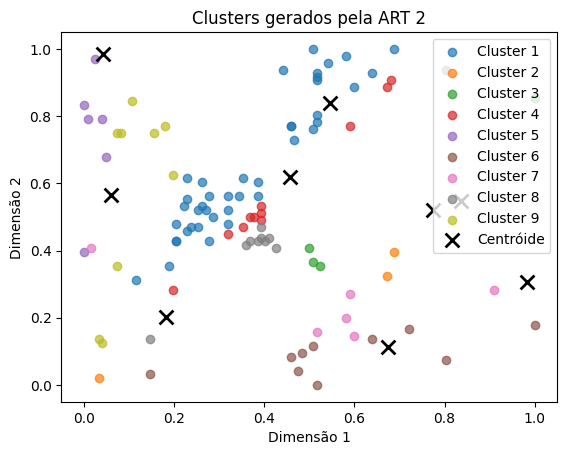

In [95]:
for (i, j) in agrupamentos:
        # Atualizar o índice de cluster para todos os pontos nos clusters i e j
        cluster_assignments[cluster_assignments == int(i)] = j

unique_clusters = np.unique(cluster_assignments)
for cluster in unique_clusters:
    cluster_data = data_normalized[np.array(cluster_assignments) == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                label=f'Cluster {cluster + 1}', alpha=0.7)

# Plotando centróides (os pesos dos clusters)
centroids = art2.weights
plt.scatter(centroids[:,0], centroids[:,1], marker='x', 
            s=100, linewidths=2, color='k', label='Centróide')

plt.title("Clusters gerados pela ART 2")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend()
plt.show()

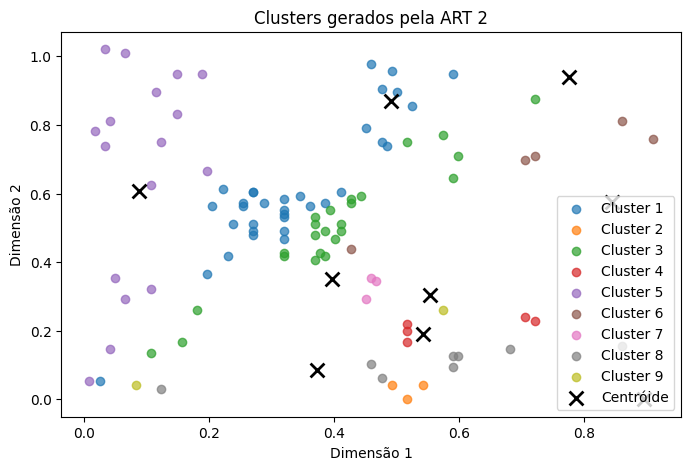

Métricas para os clusters ART:
Clusters: [0 1 2 3 4 5 6 7 8]
F_out (Dispersão inter-cluster): 0.5497502313923578
F_in (Dispersão intra-cluster) por cluster: [10.743565670235819, 1.1427573386605534, 13.755113969078192, 0.4541801144875965, 4.770913370798414, 2.351030981889925, 1.3703437883967895, 1.9240598637876754, 0.5859450431781015]
F_in (Dispersão intra-cluster): 37.097910140513065
Número de pontos por cluster: [33, 3, 24, 5, 17, 5, 3, 8, 2]
Centróides dos clusters: [array([0.49104887, 0.87113202]), array([0.89588806, 0.00143544]), array([0.7756114 , 0.93974322]), array([0.54139039, 0.18927699]), array([0.08697961, 0.60666843]), array([0.39677183, 0.3504199 ]), array([0.84411837, 0.574686  ]), array([0.37274432, 0.08383068]), array([0.5529127 , 0.30295134])]
Máxima distância (diâmetro) por cluster: [1.0594295875514455, 0.049180327868852514, 0.9617203899240503, 0.21423736873208413, 0.9690620406673258, 0.5815070730001418, 0.063035198423246, 0.7482202523921422, 0.5382583277839578]
Variâ

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Função para calcular a dispersão intra-cluster F_j
def calcular_dispersaointra(cluster_points, centroid):
    return np.sum(np.linalg.norm(cluster_points - centroid, axis=1))

# Função para calcular o diâmetro máximo do cluster
def calcular_diametro(cluster_points):
    distancias = [np.linalg.norm(point1 - point2) 
                  for i, point1 in enumerate(cluster_points) 
                  for j, point2 in enumerate(cluster_points) if i != j]
    return np.max(distancias)

# Função para calcular a variância intra-cluster
def calcular_variancia_intra(cluster_points, centroid):
    return np.var(np.linalg.norm(cluster_points - centroid, axis=1))

# Função para calcular o desvio padrão intra-cluster
def calcular_desvio_padrao_intra(variancia_intra):
    return np.sqrt(variancia_intra)

# Função para calcular a dispersão inter-cluster (F_out)
def calcular_dispersaointer(centroid_values, data_normalized, cluster_index, n_clusters):
    F_out_values = []
    for i in range(n_clusters):
        centroid_i = centroid_values[i]
        distancias = [np.linalg.norm(centroid_i - centroid_values[j]) for j in range(n_clusters) if i != j]
        F_out_values.append(np.mean(distancias))
    return np.mean(F_out_values)

data_normalized, data, n_0 = data_val_normalized, data_val, n_0_val
# Inicializando o ART2 com 2 dimensões e 5 clusters
art2 = ART2(input_dim=2, num_clusters=9, vigilance=0.3, learning_rate=0.6)
art2.train(data_normalized)
cluster_assignments = art2.predict(data_normalized)  # Clusters atribuídos

# Plotando os clusters
plt.figure(figsize=(8, 5))

unique_clusters = np.unique(cluster_assignments)
for cluster in unique_clusters:
    cluster_data = data_normalized[np.array(cluster_assignments) == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                label=f'Cluster {cluster + 1}', alpha=0.7)

# Plotando centróides (os pesos dos clusters)
centroids = art2.weights
plt.scatter(centroids[:,0], centroids[:,1], marker='x', 
            s=100, linewidths=2, color='k', label='Centróide')

plt.title("Clusters gerados pela ART 2")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend()
plt.show()

# Inicializando as listas para armazenar as métricas de cada cluster
F_j_values = []
max_distance_values = []
variancia_intra_values = []
desvio_padrao_intra_values = []
n_cluster_points_values = []
centroid_values = []

# Calculando as métricas para cada cluster
for cluster in unique_clusters:
    cluster_points = data_normalized[cluster_assignments == cluster]
    
    # Determinando o centróide do cluster (peso do cluster)
    centroid = art2.weights[cluster]
    centroid_values.append(centroid)
    
    # Número de pontos no cluster
    n_cluster_points_values.append(len(cluster_points))
    
    # Calcular a dispersão intra-cluster F_j
    F_j = calcular_dispersaointra(cluster_points, centroid)
    F_j_values.append(float(F_j))
    
    # Calcular o diâmetro máximo do cluster
    max_distance = calcular_diametro(cluster_points)
    max_distance_values.append(float(max_distance))
    
    # Calcular a variância intra-cluster
    variancia_intra = calcular_variancia_intra(cluster_points, centroid)
    variancia_intra_values.append(float(variancia_intra))
    
    # Calcular o desvio padrão intra-cluster
    desvio_padrao_intra = calcular_desvio_padrao_intra(variancia_intra)
    desvio_padrao_intra_values.append(float(desvio_padrao_intra))

# Calculando a dispersão inter-cluster (F_out)
F_out = calcular_dispersaointer(centroid_values, data_normalized, cluster_assignments, len(unique_clusters))

# Printando as métricas
print("Métricas para os clusters ART:")
print(f"Clusters: {unique_clusters}")
print(f"F_out (Dispersão inter-cluster): {F_out}")
print(f"F_in (Dispersão intra-cluster) por cluster: {F_j_values}")
print(f"F_in (Dispersão intra-cluster): {sum(F_j_values)}")
print(f"Número de pontos por cluster: {n_cluster_points_values}")
print(f"Centróides dos clusters: {centroid_values}")
print(f"Máxima distância (diâmetro) por cluster: {max_distance_values}")
print(f"Variância intra-cluster por cluster: {variancia_intra_values}")
print(f"Desvio padrão intra-cluster por cluster: {desvio_padrao_intra_values}")


In [100]:
import numpy as np
cluster_index = [i+1 for i in cluster_assignments]
# Função para calcular a distância entre dois pontos (centróides)
def calcular_distancia(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

# Função para decidir se clusters devem ser agrupados ou bipartidos
def verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points ,threshold=2, population_threshold = 5):
    n_clusters = len(centroid_values)
    agrupamentos = []  # Lista para armazenar decisões de agrupamento
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j or (i,j) in agrupamentos:
                continue
            # Calcular a distância entre os centróides dos clusters i e j
            dist = calcular_distancia(centroid_values[i], centroid_values[j])

            sigma_sum = sigma_values[i] + sigma_values[j]
            
            # Comparar a distância entre centróides com a soma das dispersões
            if dist < sigma_sum * threshold:  # Se a distância for muito pequena, agrupar
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[j]))  # Armazenar os pares de clusters que devem ser agrupados
                print(f"Clusters {np.unique(cluster_index)[i]} e {np.unique(cluster_index)[j]} podem ser agrupados. Distância: {dist}, Soma das dispersões: {sigma_sum}")
            elif F_values[i] > F_values[j] and F_values[i] > 10 * F_values[j]:  # Se F_k for muito maior em um cluster
                print(f"Cluster {np.unique(cluster_index)[i]} tem alta dispersão (F_k), considerar bipartição.")
    for i in range(n_clusters):
        if n_cluster_points[i] < population_threshold:
            # Encontrar o cluster mais próximo para agrupar
            min_dist = float('inf')
            closest_cluster = None
            for j in range(n_clusters):
                if i != j and n_cluster_points[j] >= population_threshold:  # Não agrupar com clusters de baixa população
                    dist = calcular_distancia(centroid_values[i], centroid_values[j])
                    if dist < min_dist:
                        min_dist = dist
                        closest_cluster = j
            
            if closest_cluster is not None:
                agrupamentos.append((np.unique(cluster_index)[i], np.unique(cluster_index)[closest_cluster]))
                print(f"Cluster {np.unique(cluster_index)[i]} tem população baixa e será agrupado com o cluster {np.unique(cluster_index)[closest_cluster]}. Distância: {min_dist}")

        
    
    return agrupamentos

# Exemplo de centróides, dispersões e sigma (desvio padrão)
centroid_values = centroid_values

# Exemplo de dispersão F (somatória da distância intra-cluster)
F_values = F_j_values

# Exemplo de desvio padrão intra-cluster (σ)
sigma_values = desvio_padrao_intra_values

# Chamando a função para verificar agrupamento e bipartição
agrupamentos = verificar_agrupamento_biparticao(centroid_values, F_values, sigma_values, n_cluster_points_values, 1.5, 9)

# Se necessário, implementar a lógica de bipartição para clusters com alta dispersão F_k


Clusters 1 e 3 podem ser agrupados. Distância: 0.2927171443987613, Soma das dispersões: 0.39922955921807746
Cluster 1 tem alta dispersão (F_k), considerar bipartição.
Clusters 1 e 6 podem ser agrupados. Distância: 0.5291779284636557, Soma das dispersões: 0.3903811246653633
Clusters 1 e 9 podem ser agrupados. Distância: 0.5715386414044954, Soma das dispersões: 0.429991812866805
Clusters 3 e 1 podem ser agrupados. Distância: 0.2927171443987613, Soma das dispersões: 0.39922955921807746
Cluster 3 tem alta dispersão (F_k), considerar bipartição.
Cluster 3 tem alta dispersão (F_k), considerar bipartição.
Cluster 3 tem alta dispersão (F_k), considerar bipartição.
Clusters 3 e 9 podem ser agrupados. Distância: 0.6746099629599455, Soma das dispersões: 0.46043583284321477
Clusters 4 e 6 podem ser agrupados. Distância: 0.21652150738967718, Soma das dispersões: 0.2771332172711319
Clusters 4 e 8 podem ser agrupados. Distância: 0.1988980198014841, Soma das dispersões: 0.189440024361187
Clusters 4 e 

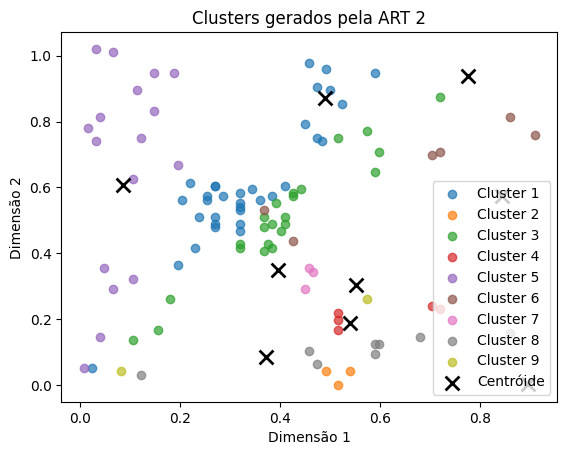

In [101]:
for (i, j) in agrupamentos:
        # Atualizar o índice de cluster para todos os pontos nos clusters i e j
        cluster_assignments[cluster_assignments == int(i)] = j

unique_clusters = np.unique(cluster_assignments)
for cluster in unique_clusters:
    cluster_data = data_normalized[np.array(cluster_assignments) == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                label=f'Cluster {cluster + 1}', alpha=0.7)

# Plotando centróides (os pesos dos clusters)
centroids = art2.weights
plt.scatter(centroids[:,0], centroids[:,1], marker='x', 
            s=100, linewidths=2, color='k', label='Centróide')

plt.title("Clusters gerados pela ART 2")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend()
plt.show()

## Resultado Final
Aqui podemos ver que existem 5 clusters de clientes com base na renda anual e na pontuação de gastos:

Cluster 0: Alta renda, baixo gasto

Cluster 1: Alta renda, alto gasto

Cluster 2: Baixa renda, alto gasto

Cluster 3: Renda média, gasto médio

Cluster 4: Baixa renda, baixo gasto